<a href="https://colab.research.google.com/github/annalimm/MultiTimeSeries_Transformer/blob/main/MultiTimeSer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
pip install yahoofinancials

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint

from yahoofinancials import YahooFinancials
from datetime import datetime

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import sys
import importlib

<ipython-input-3-fae8c0b5d6d4>:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [4]:
from google.colab import drive
drive.mount('/content/drive')

sys.path.append('/content/drive/My Drive/Colab Notebooks/MultiTimeSeries/functions')
# from preprocessing import df_split, chunks
# from plot import split_plot

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import preprocessing, plot, embedding, model, helpers
sys.path.append('/content/drive/My Drive/Colab Notebooks/MultiTimeSeries/Stock_data')
import yahoo_data

In [63]:
importlib.reload(yahoo_data)

<module 'yahoo_data' from '/content/drive/My Drive/Colab Notebooks/MultiTimeSeries/Stock_data/yahoo_data.py'>

# Data

Here we work with one stock

In [8]:
# tickers = ['AAPL', 'MSFT', 'GOOGL']
tickers = ['IBM']
start_date = '1960-01-01'
end_date = '2022-02-25'

stocks_data = yahoo_data.fetch_tickers_data(tickers, start_date, end_date)
print(stocks_data)

                 DateTime        Open        High         Low       Close  \
0     1962-01-02 14:30:00    7.374124    7.374124    7.291268    1.573409   
1     1962-01-03 14:30:00    7.291268    7.355003    7.291268    1.587164   
2     1962-01-04 14:30:00    7.355003    7.355003    7.278521    1.571347   
3     1962-01-05 14:30:00    7.272148    7.272148    7.125558    1.540402   
4     1962-01-08 14:30:00    7.131931    7.131931    6.947100    1.511519   
...                   ...         ...         ...         ...         ...   
15137 2022-02-17 14:30:00  128.050003  128.500000  124.849998  116.099701   
15138 2022-02-18 14:30:00  124.940002  125.440002  123.610001  115.523705   
15139 2022-02-22 14:30:00  124.199997  125.000000  122.680000  115.124222   
15140 2022-02-23 14:30:00  124.379997  124.699997  121.870003  113.405540   
15141 2022-02-24 14:30:00  120.000000  122.099998  118.809998  113.312645   

        Volume  
0       407940  
1       305955  
2       274575  
3      

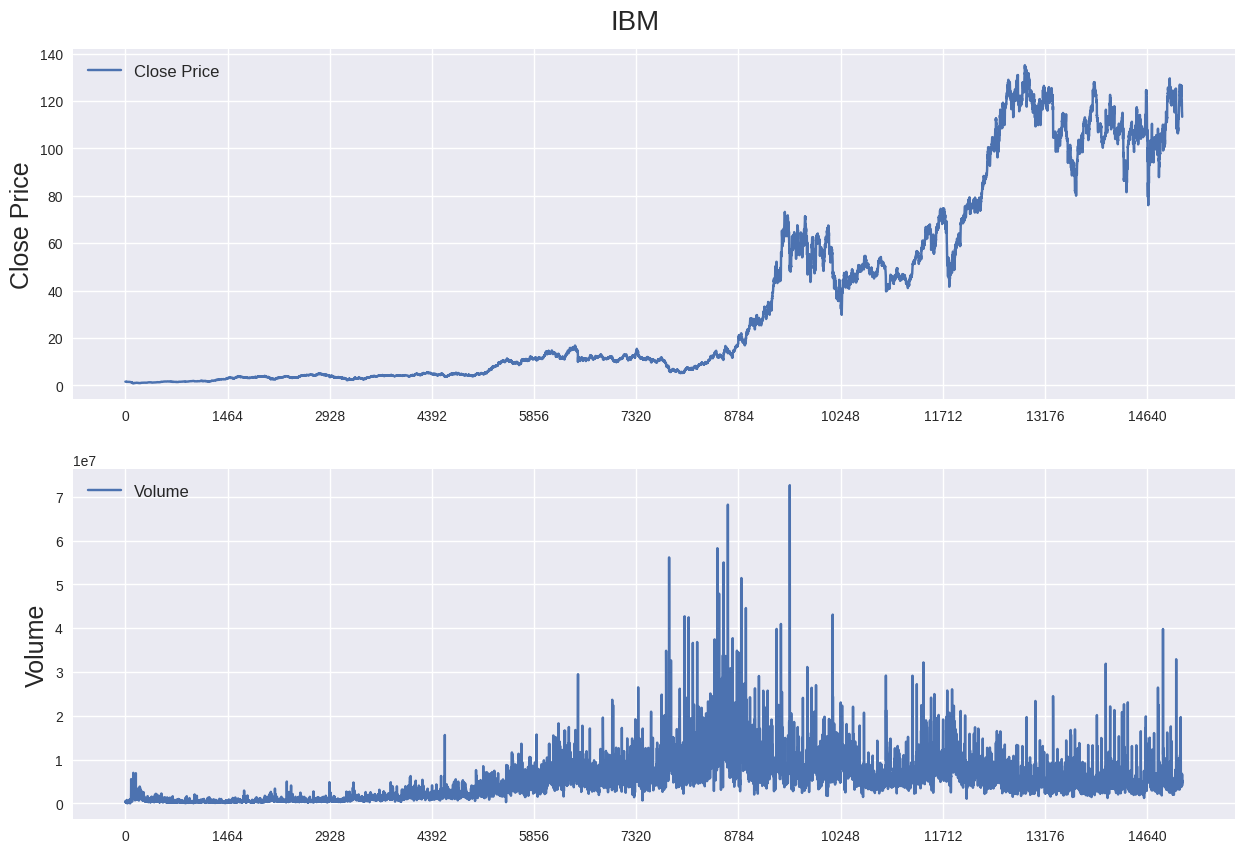

In [9]:
yahoo_data.stock_plot("IBM", stocks_data)

# Preprocessing

## data converting

In [10]:
# Data converts for better stationarity:
# price converts to daily stock returns and volume converts to daily volume changes

def df_convert(stock_df):
    df = pd.DataFrame()
    # the percentage change between the current element and the previous element
    df['Open'] = stock_df['Open'].pct_change()
    df['High'] = stock_df['High'].pct_change()
    df['Low'] = stock_df['Low'].pct_change()
    df['Close'] = stock_df['Close'].pct_change()
    df['Volume'] = stock_df['Volume'].pct_change()

    df.dropna(how='any', axis=0, inplace=True)
    return df

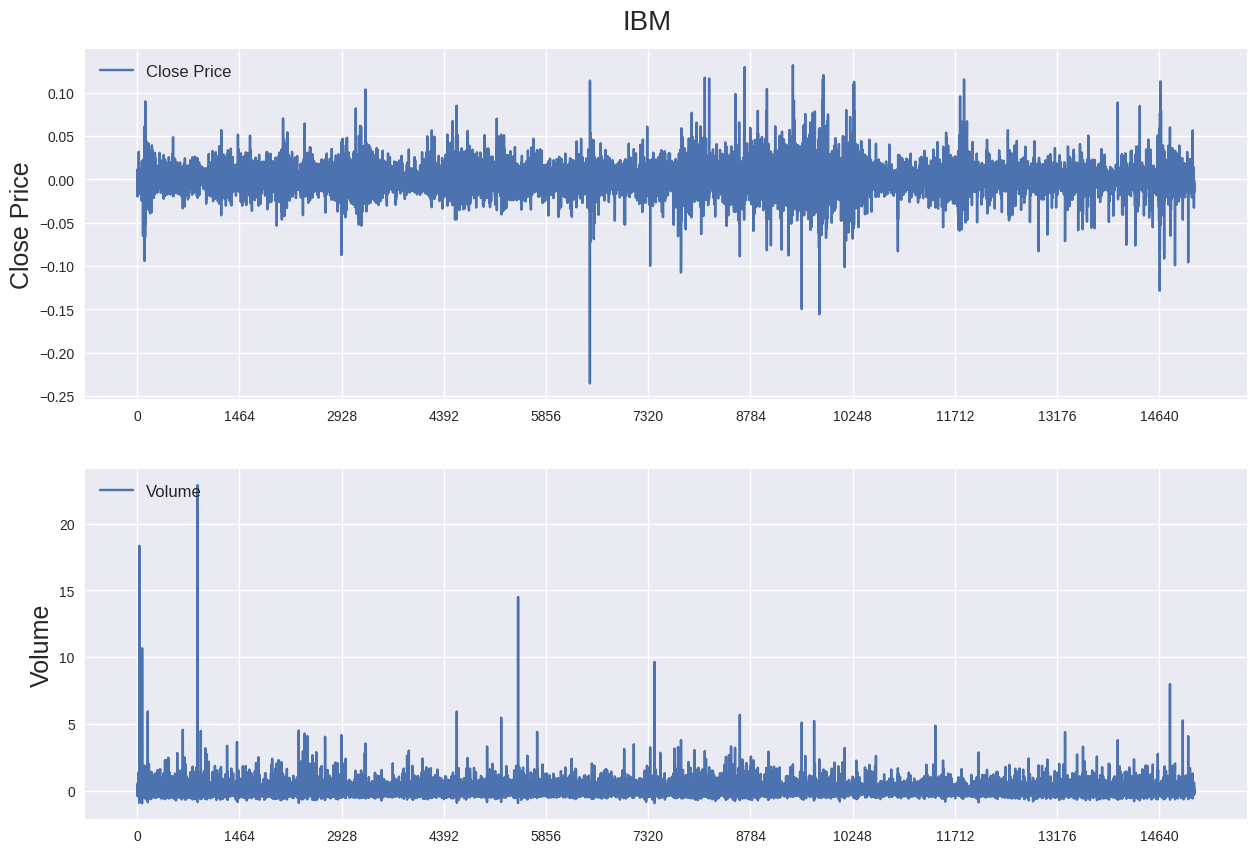

In [11]:
conv_df = df_convert(stocks_data)
yahoo_data.stock_plot("IBM", conv_df)

## min-max normalization

important not only in terms of understandability of results, but also for training itself

activations (the result of applying a weighted sum of the inputs, followed by an activation function (e.g., ReLU, sigmoid, or tanh)) can become very large or very small during forward and backward passes. Large activations can lead to gradients that explode, making it challenging to train the network. On the other hand, very small activations can result in vanishing gradients, which hinder learning.

We normalise test data relying only on train data, so that it will not give us the information from the future and there will be no data leakage

In [12]:
# i do not entirely understand, why this type of normalization gives a small mape;
# it's muuuch better comparing with norm-ion with min/max counting for every column separately
def mm_norm(df):
    min_return = min(df[: int(len(df)*0.8)][['Open', 'High', 'Low', 'Close']].min(axis=0))
    max_return = max(df[: int(len(df)*0.8)][['Open', 'High', 'Low', 'Close']].max(axis=0))
    min_volume = df[: int(len(df)*0.8)]['Volume'].min(axis=0)
    max_volume = df[: int(len(df)*0.8)]['Volume'].max(axis=0)

    # normilize price columns (0-1 range)
    df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
    df['High'] = (df['High'] - min_return) / (max_return - min_return)
    df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
    df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

    # normilize volume columns (0-1 range)
    df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)
    return df

In [13]:
preproc_df = mm_norm(conv_df)
preproc_df

Open      High       Low     Close    Volume
1      0.564778  0.585893  0.592227  0.613584  0.029311
2      0.613582  0.592227  0.587956  0.567882  0.035499
3      0.564707  0.564707  0.540887  0.544119  0.056595
4      0.545124  0.545124  0.531045  0.546420  0.060364
5      0.559480  0.607510  0.623604  0.621125  0.035780
...         ...       ...       ...       ...       ...
15137  0.565807  0.555894  0.527278  0.512612  0.056347
15138  0.532895  0.534053  0.567964  0.580107  0.026294
15139  0.577758  0.583658  0.573847  0.583780  0.046548
15140  0.595768  0.586364  0.576098  0.555757  0.029892
15141  0.506200  0.541292  0.530888  0.590226  0.065246

[15141 rows x 5 columns]

## train, test, validation data

In [14]:
df_train, df_val, df_test = preprocessing.df_split(preproc_df)

Train df shape: (12112, 5)
Val df shape: (1514, 5)
Test df shape: (1515, 5)


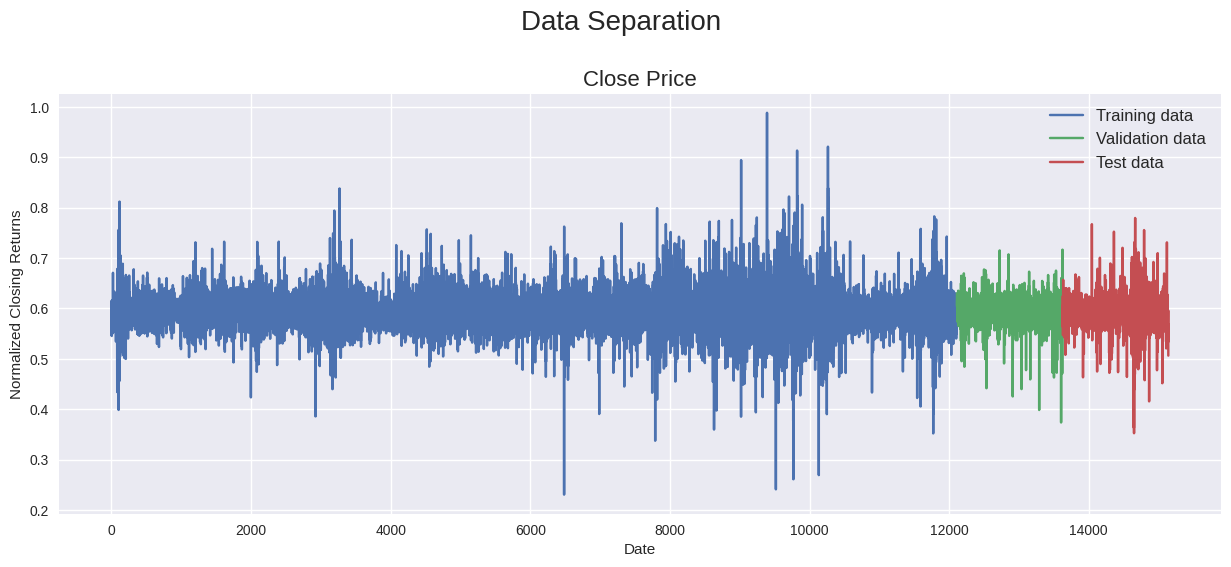

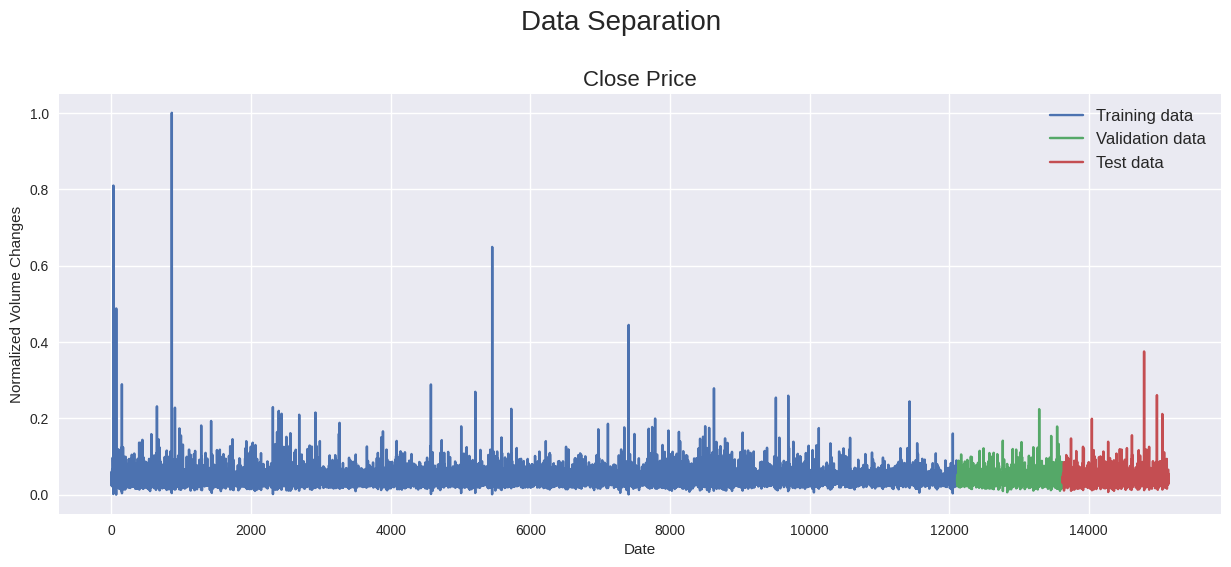

In [16]:
plot.split_plot(df_train, df_val, df_test, param = 'Open', title =  "Close Price", y_lbl = 'Normalized Closing Returns')
plot.split_plot(df_train, df_val, df_test, param = 'Volume', title =  "Close Price", y_lbl = 'Normalized Volume Changes')

## "rolling window" or "sliding window" approach for time-series

Here we create sequences of data points, which we then use as an imput for training.

Sequence length parametr is important for Transformer.

"A longer sequence can capture longer-term dependencies, but it might also introduce more complexity and computation."

(Plan for sometime:

- Begin with an initial sequence length and use it for model training.

- Monitor the model's performance on the validation set using this sequence length.

- Experiment with different sequence lengths and train separate models with varying sequence lengths.)

In [50]:
seq_len = 8 # = 128 in other word timesteps
target_col = 3

In [51]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocessing.chunks(seq_len, df_train, df_val, df_test, target_col)

Train chunks set shape:  (12104, 8, 5) (12104,)
Val chunks set shape:  (1506, 8, 5) (1506,)
Test chunks set shape:  (1507, 8, 5) (1507,)


# TimeEmbedding

ChatGPT: "Time embeddings can be a crucial component in a time-series Transformer model, especially when dealing with sequential data where the temporal order of the data points matters. Time embeddings help the model capture temporal patterns and dependencies in the data."

In [ ]:
# # later plan: to evaluate diff emb approaches

# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# from your_embedding_library import EmbeddingTechnique1, EmbeddingTechnique2, EmbeddingTechnique3

# # Load your time-series data (replace with your data loading code)
# data = pd.read_csv('your_time_series_data.csv')

# # Split the data into training, validation, and test sets
# train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)
# train_data, val_data = train_test_split(train_data, test_size=0.2, shuffle=False)

# # Define a function to evaluate an embedding technique
# def evaluate_embedding(embedding_technique, train_data, val_data, test_data):
#     # Apply the embedding technique to the data
#     train_embedded = embedding_technique.fit_transform(train_data)
#     val_embedded = embedding_technique.transform(val_data)
#     test_embedded = embedding_technique.transform(test_data)

#     # Train a model on the embedded data (replace with your model training code)
#     model = YourModel()
#     model.fit(train_embedded, train_labels)

#     # Make predictions on the validation and test sets
#     val_predictions = model.predict(val_embedded)
#     test_predictions = model.predict(test_embedded)

#     # Calculate the evaluation metric (MSE in this example)
#     val_mse = mean_squared_error(val_labels, val_predictions)
#     test_mse = mean_squared_error(test_labels, test_predictions)

#     return val_mse, test_mse

# # Instantiate different embedding techniques
# embedding1 = EmbeddingTechnique1()
# embedding2 = EmbeddingTechnique2()
# embedding3 = EmbeddingTechnique3()

# # Evaluate each embedding technique
# val_mse1, test_mse1 = evaluate_embedding(embedding1, train_data, val_data, test_data)
# val_mse2, test_mse2 = evaluate_embedding(embedding2, train_data, val_data, test_data)
# val_mse3, test_mse3 = evaluate_embedding(embedding3, train_data, val_data, test_data)

# # Compare and report the results
# print("Embedding Technique 1 - Validation MSE:", val_mse1)
# print("Embedding Technique 1 - Test MSE:", test_mse1)

# print("Embedding Technique 2 - Validation MSE:", val_mse2)
# print("Embedding Technique 2 - Test MSE:", test_mse2)

# print("Embedding Technique 3 - Validation MSE:", val_mse3)
# print("Embedding Technique 3 - Test MSE:", test_mse3)

# Model (tf realization)

model's imput [#batchs, #timesteps, features]

batchs -- how many stocks sequences we want to feed at once

With prepared tensorflow.layers Model (Kaggle_Teans & FordATS notebooks) it didn't work. Probably, cause it's not adapted for multiple time-series

In [ ]:
# def pred_plot(name_str, train_pred, val_pred, test_pred):

#     fig = plt.figure(figsize=(15,20))
#     st = fig.suptitle(name_str, fontsize=22)
#     st.set_y(0.92)

#     #Plot training data results
#     ax11 = fig.add_subplot(311)
#     ax11.plot(df_train.values[:, 3], label='Closing Returns') # original data
#     ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted IBM Closing Returns')
#     ax11.set_title("Training Data", fontsize=18)
#     ax11.set_xlabel('Date')
#     ax11.set_ylabel('Closing Returns')
#     ax11.legend(loc="best", fontsize=12)

#     #Plot validation data results
#     ax21 = fig.add_subplot(312)
#     ax21.plot(df_val.values[:, 3], label='Closing Returns')
#     ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted IBM Closing Returns')
#     ax21.set_title("Validation Data", fontsize=18)
#     ax21.set_xlabel('Date')
#     ax21.set_ylabel('Closing Returns')
#     ax21.legend(loc="best", fontsize=12)

#     #Plot test data results
#     ax31 = fig.add_subplot(313)
#     ax31.plot(df_test.values[:, 3], label='Closing Returns')
#     ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted IBM Closing Returns')
#     ax31.set_title("Test Data", fontsize=18)
#     ax31.set_xlabel('Date')
#     ax31.set_ylabel('Closing Returns')
#     ax31.legend(loc="best", fontsize=12)

### Without timeEmb. (old irrelevant results)

#### seq_len = 128

In [ ]:
path_model_128 = '/content/drive/My Drive/Colab Notebooks/MultiTimeSeries/Transf_128+noTimeEmb.hdf5'

In [ ]:
model_128 = create_model_noTimEmb()
model_128.save(path_model_128)

callback = tf.keras.callbacks.ModelCheckpoint(path_model_128,
                                              monitor='val_loss',
                                              save_best_only=True,
                                              save_weights_only=False,  # Save the entire model (including architecture)
                                              verbose=1)

model_128.fit(X_train, y_train,
          batch_size=batch_size,
          epochs = 4,
          callbacks=callback,
          validation_data=(X_val, y_val))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/4
379/379 [==============================] - ETA: 0s - loss: 0.0254 - mae: 0.0905 - mape: 15.4667
Epoch 1: val_loss improved from inf to 0.00097, saving model to /content/drive/My Drive/Colab Notebooks/MultiTimeSeries/Transf_128+noTimeEmb.hdf5
379/379 [==============================] - 135s 212ms/step - loss: 0.0254 - mae: 0.0905 - mape: 15.4667 - val_loss: 9.6683e-04 - val_mae: 0.0226 - val_mape: 3.8110
Epoch 2/4
379/379 [==============================] - ETA: 0s - loss: 0.0027 - mae: 0.0394 - mape: 6.9632
Epoch 2: val_loss did not improve from 0.00097
379/379 [==============================] - 75s 197ms/step - loss: 0.0027 - mae: 0.0394 - mape: 6.9632 - val_loss: 0.0011 - val_mae: 0.0249 - val_mape: 4.3379
Epoch 3/4
379/379 [==============================] - ETA: 0s - loss: 0.0026 - mae: 0.0382 - mape: 6.7494
Epoch 3: val_loss did not improve from 0.00097
379/379 [==============================] - 93s 245ms/step - loss: 0.0026 - mae: 0.0382 - mape: 6.7494 - val_loss: 0.0012 -

In [ ]:
loaded_model_128 = tf.keras.models.load_model(path_model_128,
                                         custom_objects={'SingleAttention': SingleAttention,
                                                         'MultiAttention': MultiAttention,
                                                         'TransformerEncoder': TransformerEncoder})

train_pred_mod128 = loaded_model_128.predict(X_train)
val_pred_mod128 = loaded_model_128.predict(X_val)
test_pred_mod128 = loaded_model_128.predict(X_test)

48/48 [==============================] - 4s 90ms/step


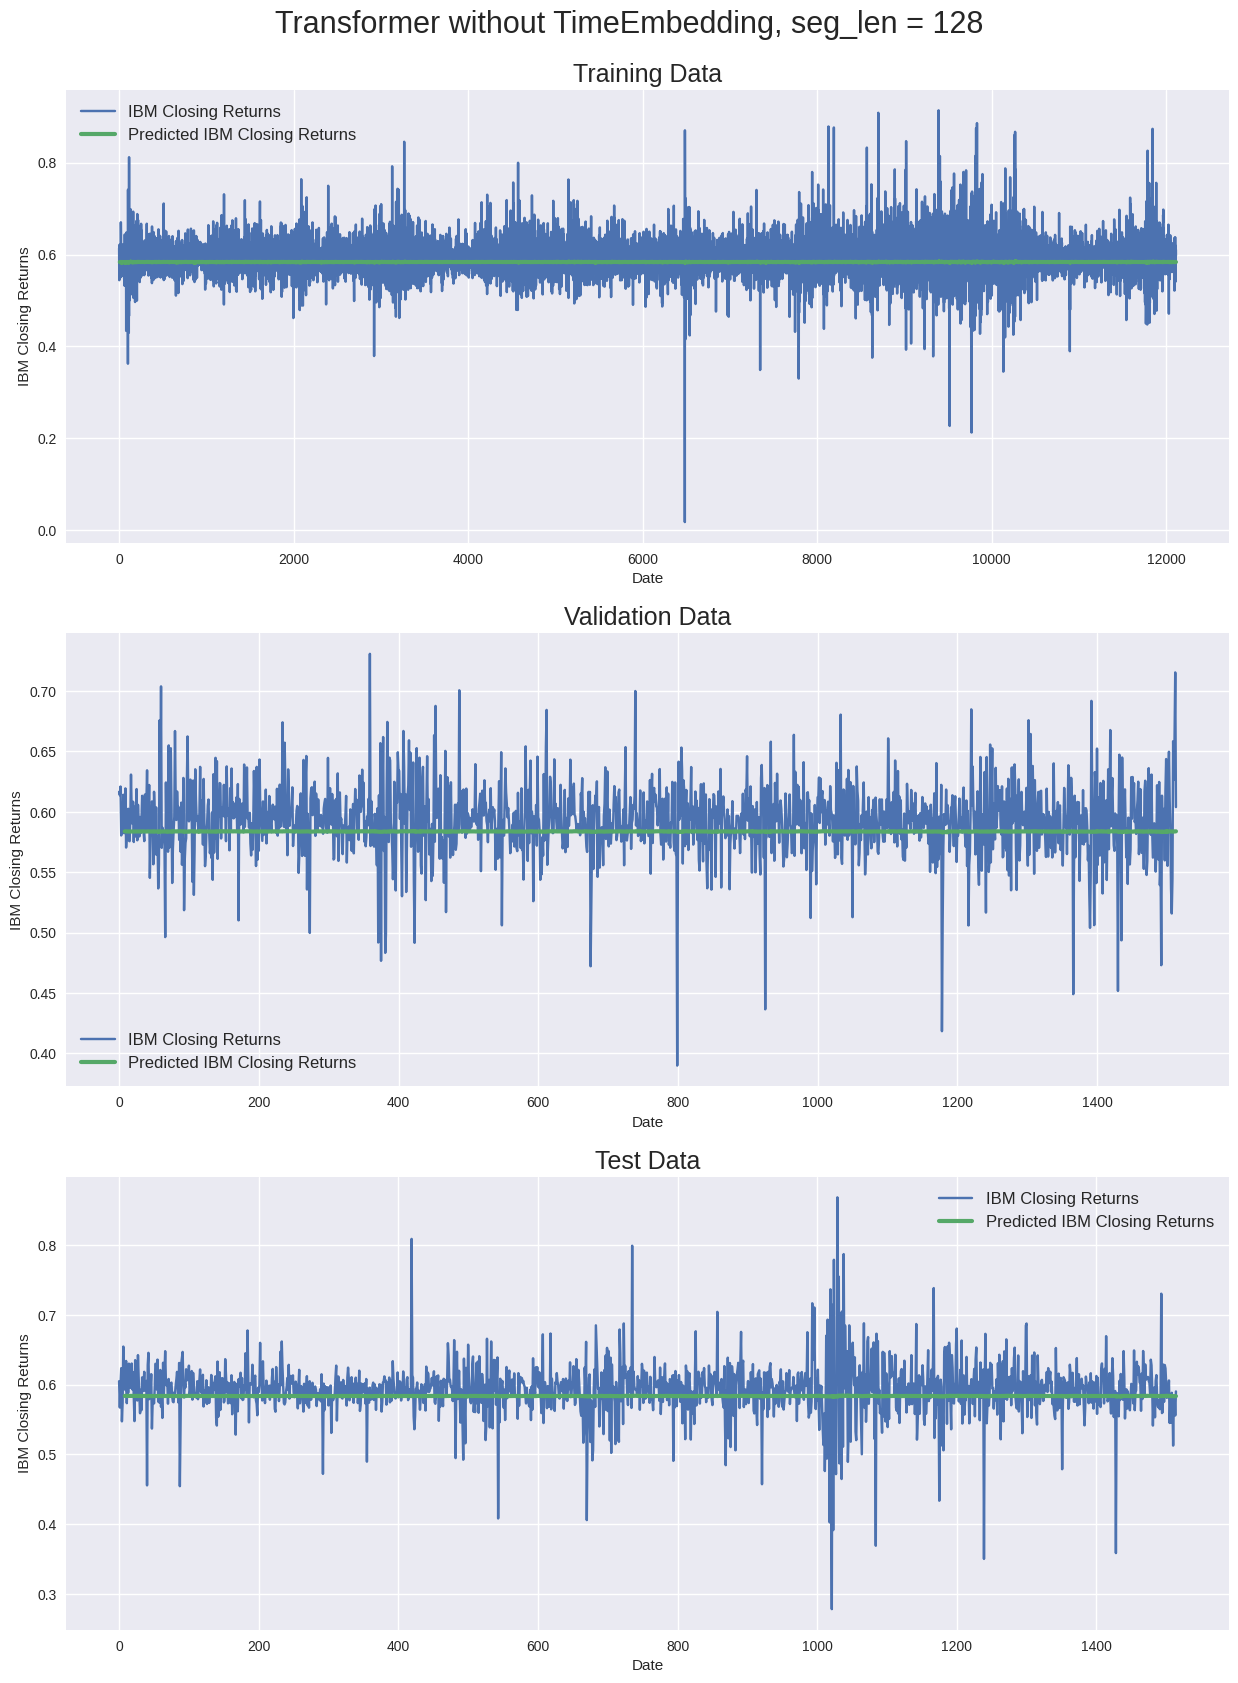

In [ ]:
pred_plot("Transformer without TimeEmbedding, seg_len = 128", train_pred_mod128, val_pred_mod128, test_pred_mod128)

#### seq_len = 8

In [ ]:
path_model_8 = '/content/drive/My Drive/Colab Notebooks/MultiTimeSeries/Transf_8+noTimeEmb.hdf5'

In [ ]:
model_8 = create_model_noTimEmb()
model_8.save(path_model_8)

callback = tf.keras.callbacks.ModelCheckpoint(path_model_8,
                                              monitor='val_loss',
                                              save_best_only=True,
                                              save_weights_only=False,  # Save the entire model (including architecture)
                                              verbose=1)

model_8.fit(X_train, y_train,
          batch_size=batch_size,
          epochs = 4,
          callbacks=callback,
          validation_data=(X_val, y_val))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/4
260/260 [==============================] - ETA: 0s - loss: 0.0266 - mae: 0.0942 - mape: 74467.4531
Epoch 1: val_loss improved from inf to 0.00028, saving model to /content/drive/My Drive/Colab Notebooks/MultiTimeSeries/Transf_8+noTimeEmb.hdf5
260/260 [==============================] - 125s 210ms/step - loss: 0.0266 - mae: 0.0942 - mape: 74467.4531 - val_loss: 2.7876e-04 - val_mae: 0.0121 - val_mape: 2.1024
Epoch 2/4
260/260 [==============================] - ETA: 0s - loss: 0.0026 - mae: 0.0392 - mape: 64826.4023
Epoch 2: val_loss did not improve from 0.00028
260/260 [==============================] - 45s 172ms/step - loss: 0.0026 - mae: 0.0392 - mape: 64826.4023 - val_loss: 5.8495e-04 - val_mae: 0.0205 - val_mape: 3.5383
Epoch 3/4
260/260 [==============================] - ETA: 0s - loss: 0.0021 - mae: 0.0354 - mape: 70783.2031
Epoch 3: val_loss improved from 0.00028 to 0.00025, saving model to /content/drive/My Drive/Colab Notebooks/MultiTimeSeries/Transf_8+noTimeEmb.hdf5
2

In [ ]:
# Load the model from the Google Drive
loaded_model_8 = tf.keras.models.load_model(path_model_8,
                                         custom_objects={'SingleAttention': SingleAttention,
                                                         'MultiAttention': MultiAttention,
                                                         'TransformerEncoder': TransformerEncoder})

train_pred_mod8 = loaded_model_8.predict(X_train)
val_pred_mod8 = loaded_model_8.predict(X_val)
test_pred_mod8 = loaded_model_8.predict(X_test)

33/33 [==============================] - 2s 45ms/step


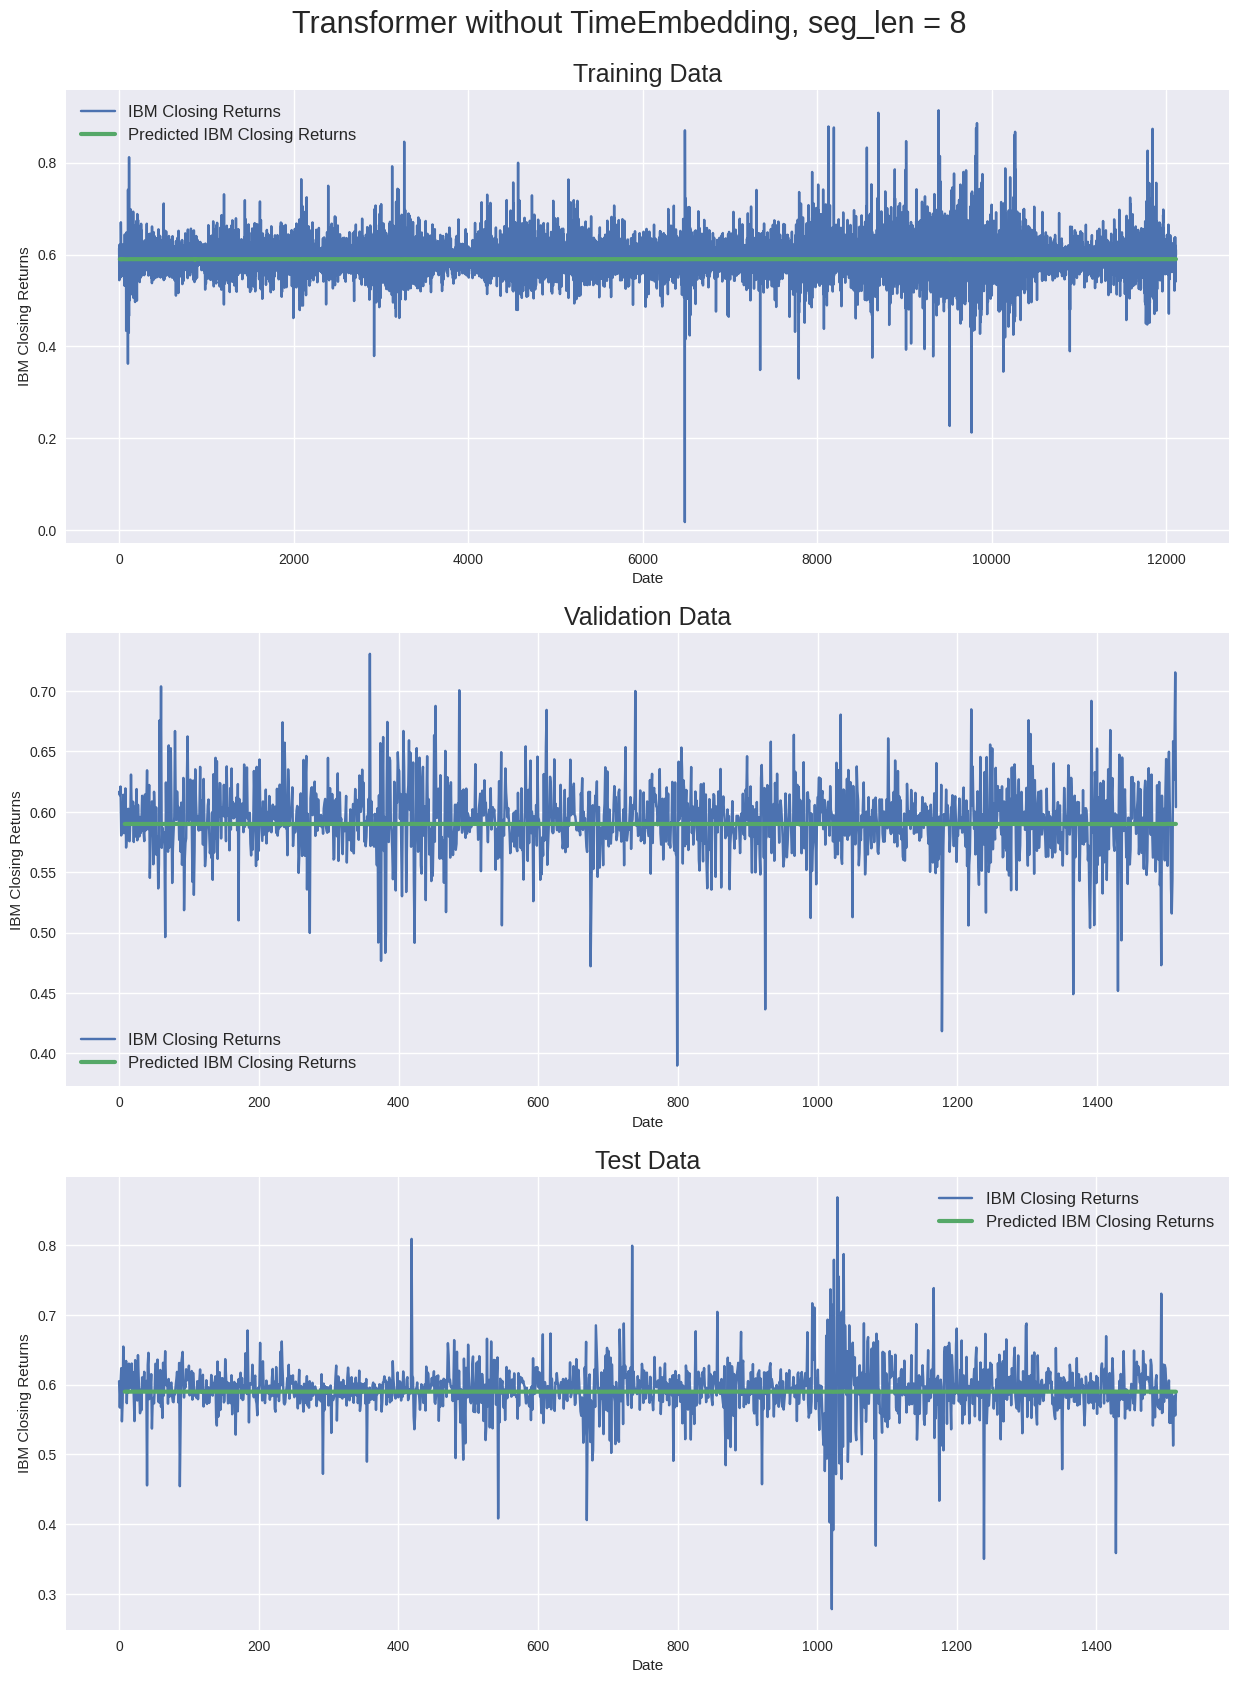

In [ ]:
pred_plot("Transformer without TimeEmbedding, seg_len = 8", train_pred_mod8, val_pred_mod8, test_pred_mod8)

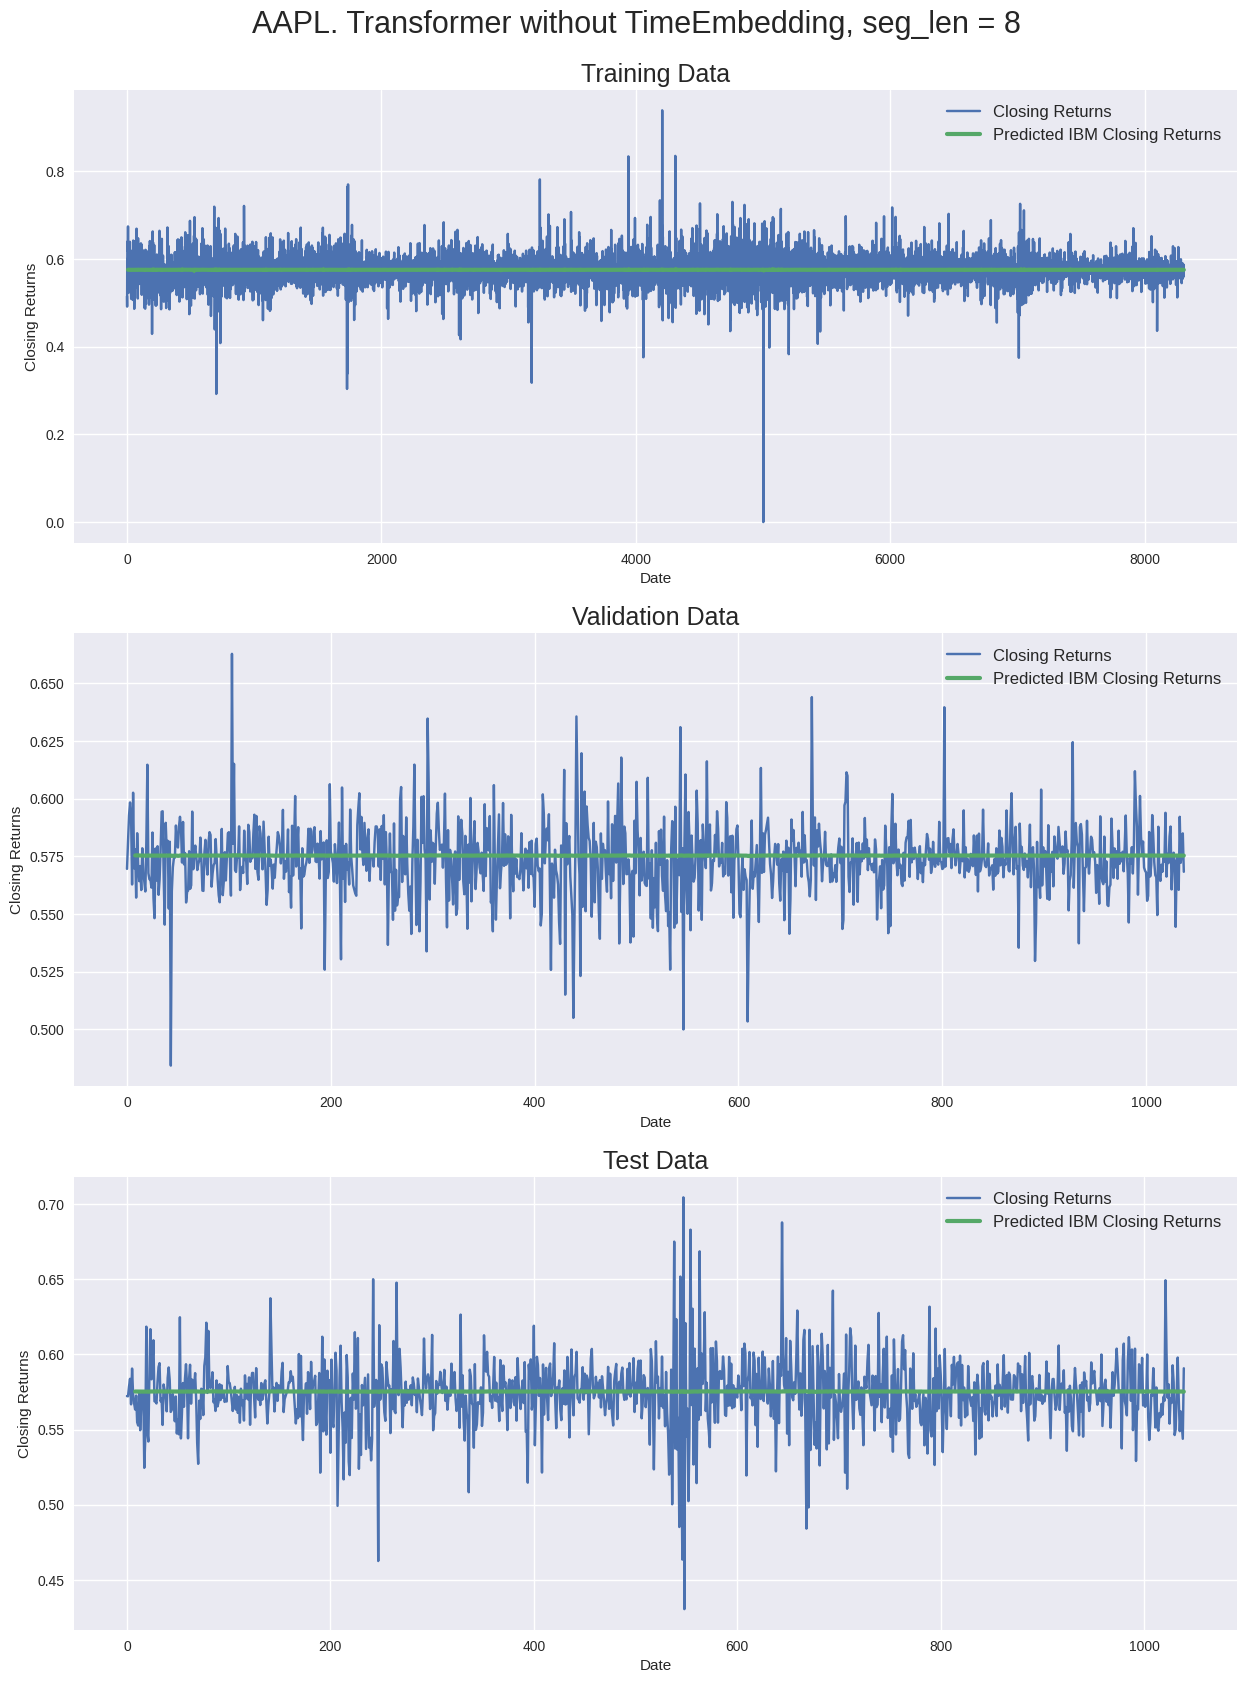

In [ ]:
pred_plot("AAPL. Transformer without TimeEmbedding, seg_len = 8", train_pred_mod8, val_pred_mod8, test_pred_mod8)

### With TimeEmb

In [52]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):

    # Normalization and Attention
    # "EMBEDDING LAYER"
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    # "ATTENTION LAYER"
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # FEED FORWARD Part - you can stick anything here or just delete the whole section - it will still work.
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation = "relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    for _ in range(num_transformer_blocks):  # This is what stacks our transformer blocks
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x) #this is a pass-through
    return keras.Model(inputs, outputs)

In [53]:
X_train.shape[1:]

(8, 5)

In [54]:
input_shape = X_train.shape[1:]

from tensorflow.keras import layers

In [55]:
def lr_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

callbacks = [
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.LearningRateScheduler(lr_scheduler)
            ]


In [24]:
#seq_len = 8
# batch_size = 32
# d_k = 256
# d_v = 256
# n_heads = 12
# ff_dim = 256

In [56]:
model = build_model(
    input_shape,
    head_size=46, # Embedding size for attention
    num_heads= 60, #20, # Number of attention heads
    ff_dim=55, # Hidden layer size in feed forward network inside transformer
    num_transformer_blocks=5,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.14,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mean_squared_error"],
)
#model.summary()


history = model.fit(
    X_train,
    y_train,
    # validation_split=0.2,
    epochs=2,
    batch_size=20,
    callbacks=callbacks,
    validation_data=(X_val, y_val)
)

Epoch 1/2
606/606 [==============================] - 132s 200ms/step - loss: 0.2249 - mean_squared_error: 0.2249 - val_loss: 0.0551 - val_mean_squared_error: 0.0551 - lr: 1.0000e-06
Epoch 2/2
606/606 [==============================] - 114s 188ms/step - loss: 0.0462 - mean_squared_error: 0.0462 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - lr: 3.4300e-05


Looks like overfitting!!!

In [57]:
a = model.predict(X_train)

379/379 [==============================] - 37s 96ms/step


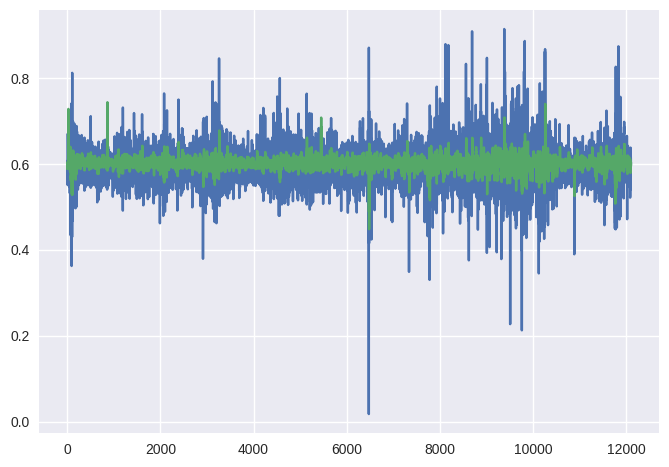

In [58]:
# 2 epo w 60 num_heads
plt.plot(y_train, label='original data')
plt.plot(a, label='predicted data')

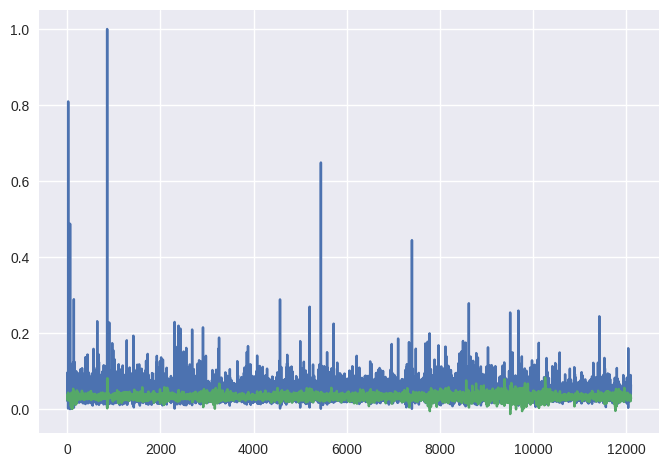

In [49]:
# 2 epo w 20 num_heads
plt.plot(y_train, label='original data')
plt.plot(a, label='predicted data')

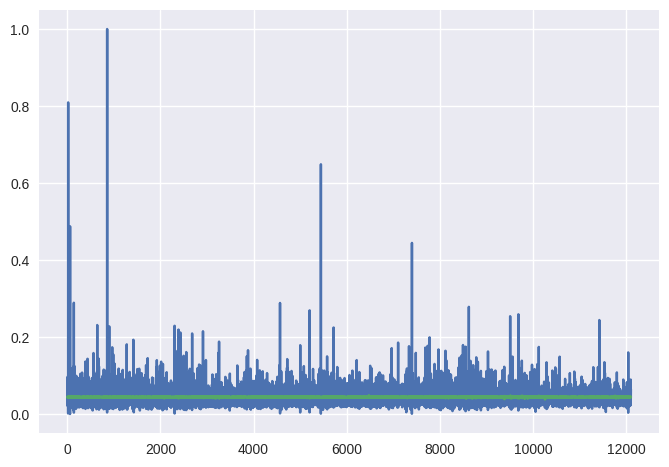

In [46]:
# 4 epo w 60 num_heads
plt.plot(y_train, label='original data')
plt.plot(a, label='predicted data')

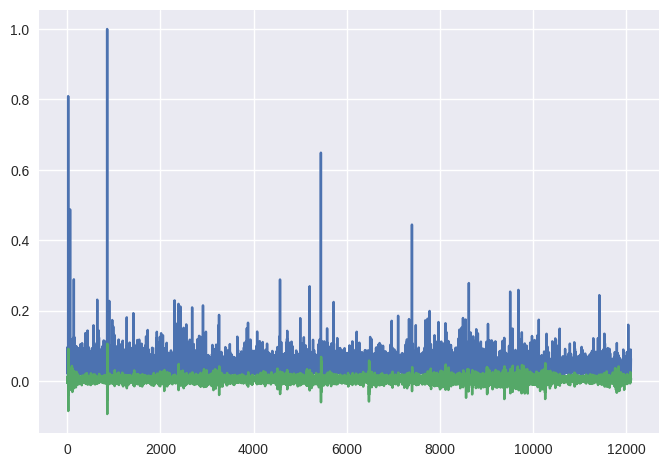

In [43]:
# 1 epo
plt.plot(y_train, label='original data')
plt.plot(a, label='predicted data')

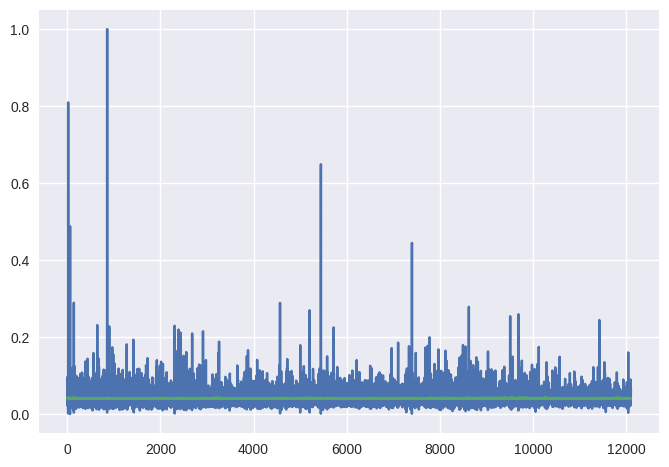

In [39]:
# 10 epo
plt.plot(y_train, label='original data')
plt.plot(a, label='predicted data')

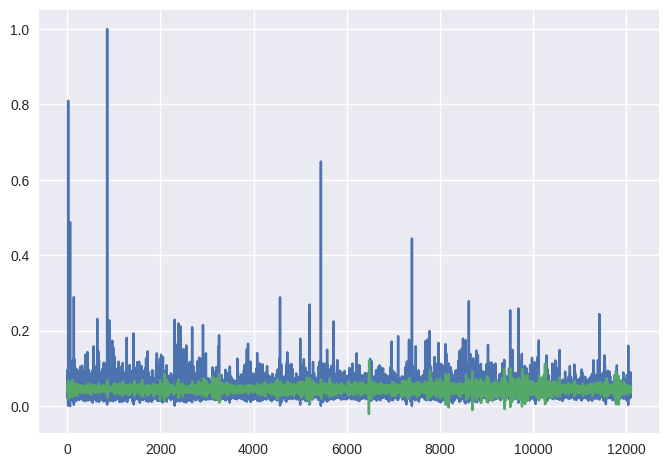

In [29]:
#4 epo
plt.plot(y_train, label='original data')
plt.plot(a, label='predicted data')

In [37]:
b = model.predict(X_val)

48/48 [==============================] - 1s 29ms/step


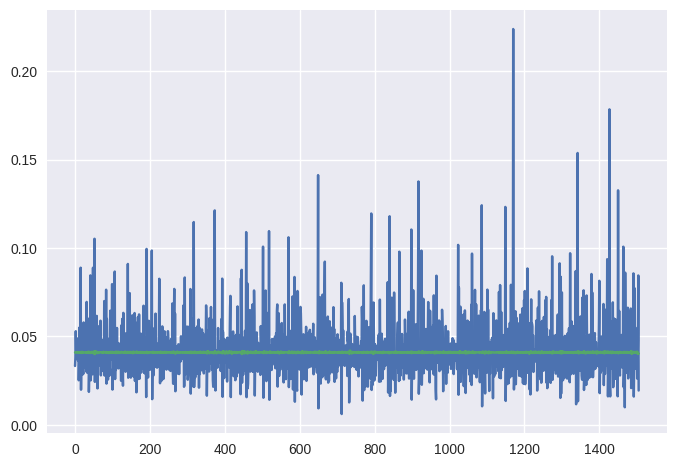

In [40]:
plt.plot(y_val, label='original data')
plt.plot(b, label='predicted data')

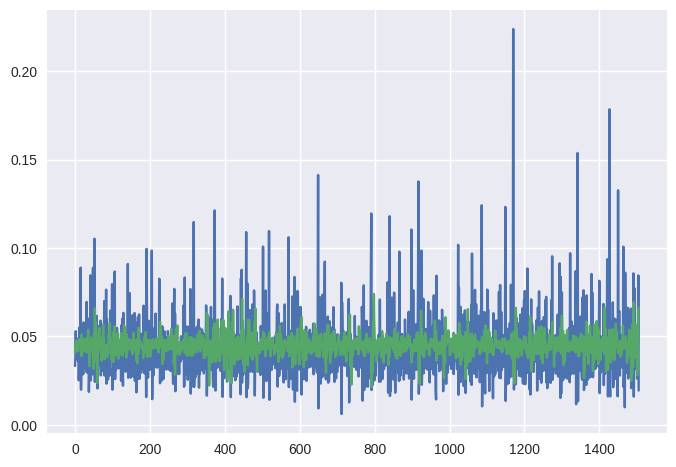

In [31]:
plt.plot(y_val, label='original data')
plt.plot(b, label='predicted data')

In [38]:
c = model.predict(X_test)

48/48 [==============================] - 1s 28ms/step


In [ ]:
plt.plot(y_test, label='original data')
plt.plot(c, label='predicted data')

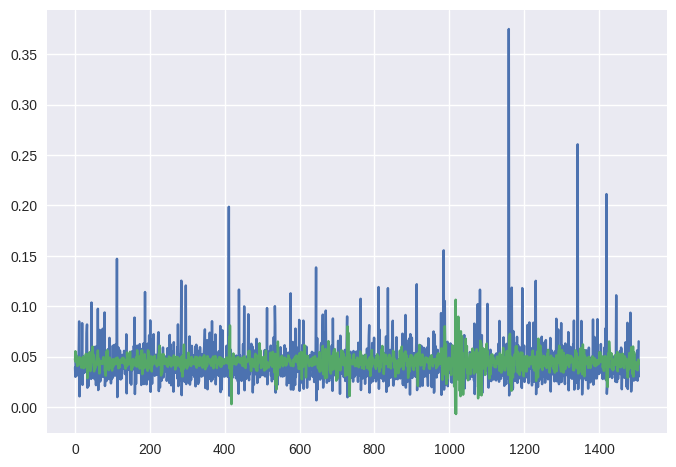

In [34]:
plt.plot(y_test, label='original data')
plt.plot(c, label='predicted data')

In [ ]:
path_model_TimeEmb = '/content/drive/My Drive/Colab Notebooks/MultiTimeSeries/Transf_128+TimeEmb.hdf5'

In [ ]:
batch_size = 20 # = 32
d_k = 256
d_v = 256
n_heads = 60 #12
ff_dim = 55 # = 256 Hidden layer size in feed forward network inside transformer

In [ ]:
importlib.reload(model)

<module 'model' from '/Users/ash/Desktop/GIT/NN/Stocks_Transformer/MultiTimeSeries_Transformer/model.py'>

In [ ]:
callbacks = [
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.LearningRateScheduler(lr_scheduler)
            ]

time_callback = TimeCallback()

model = model.model_withTimeEmb()

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs = 4,
          callbacks=[callback, time_callback],
          callbacks=[time_callback],
          validation_data=(X_val, y_val))

Epoch 1/6
606/606 [==============================] - 299s 319ms/step - loss: 0.0160 - mae: 0.0724 - mape: 12.5079 - val_loss: 9.5129e-04 - val_mae: 0.0223 - val_mape: 3.7691
Epoch 2/6
606/606 [==============================] - 206s 340ms/step - loss: 0.0027 - mae: 0.0393 - mape: 6.9146 - val_loss: 9.4473e-04 - val_mae: 0.0222 - val_mape: 3.7526
Epoch 3/6
606/606 [==============================] - 204s 337ms/step - loss: 0.0025 - mae: 0.0379 - mape: 6.7004 - val_loss: 8.9431e-04 - val_mae: 0.0213 - val_mape: 3.6678
Epoch 4/6
606/606 [==============================] - 198s 326ms/step - loss: 0.0024 - mae: 0.0369 - mape: 6.5417 - val_loss: 9.0397e-04 - val_mae: 0.0215 - val_mape: 3.6532
Epoch 5/6
606/606 [==============================] - 204s 337ms/step - loss: 0.0023 - mae: 0.0358 - mape: 6.3698 - val_loss: 9.1547e-04 - val_mae: 0.0217 - val_mape: 3.7446
Epoch 6/6
606/606 [==============================] - 202s 334ms/step - loss: 0.0022 - mae: 0.0354 - mape: 6.2808 - val_loss: 9.8050e-0

In [ ]:
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

48/48 [==============================] - 7s 154ms/step


In [ ]:
X_train.shape, y_train.shape

((11984, 128, 5), (11984,))

In [ ]:
train_pred, y_train

(array([[0.6024645 ],
        [0.60245144],
        [0.60245454],
        ...,
        [0.6024562 ],
        [0.6024757 ],
        [0.60245854]], dtype=float32),
 array([0.5573299 , 0.62940106, 0.65151262, ..., 0.58429704, 0.61052729,
        0.59755817]))

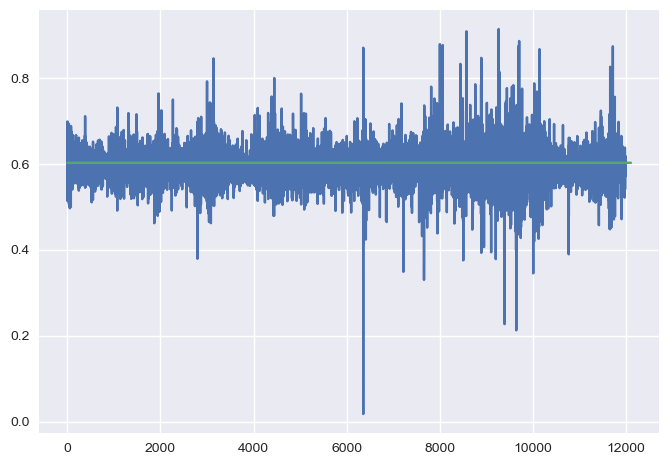

In [ ]:
plt.plot(y_train, label='original data')
plt.plot(train_pred, label='predicted data')
#plt.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='predicted data')

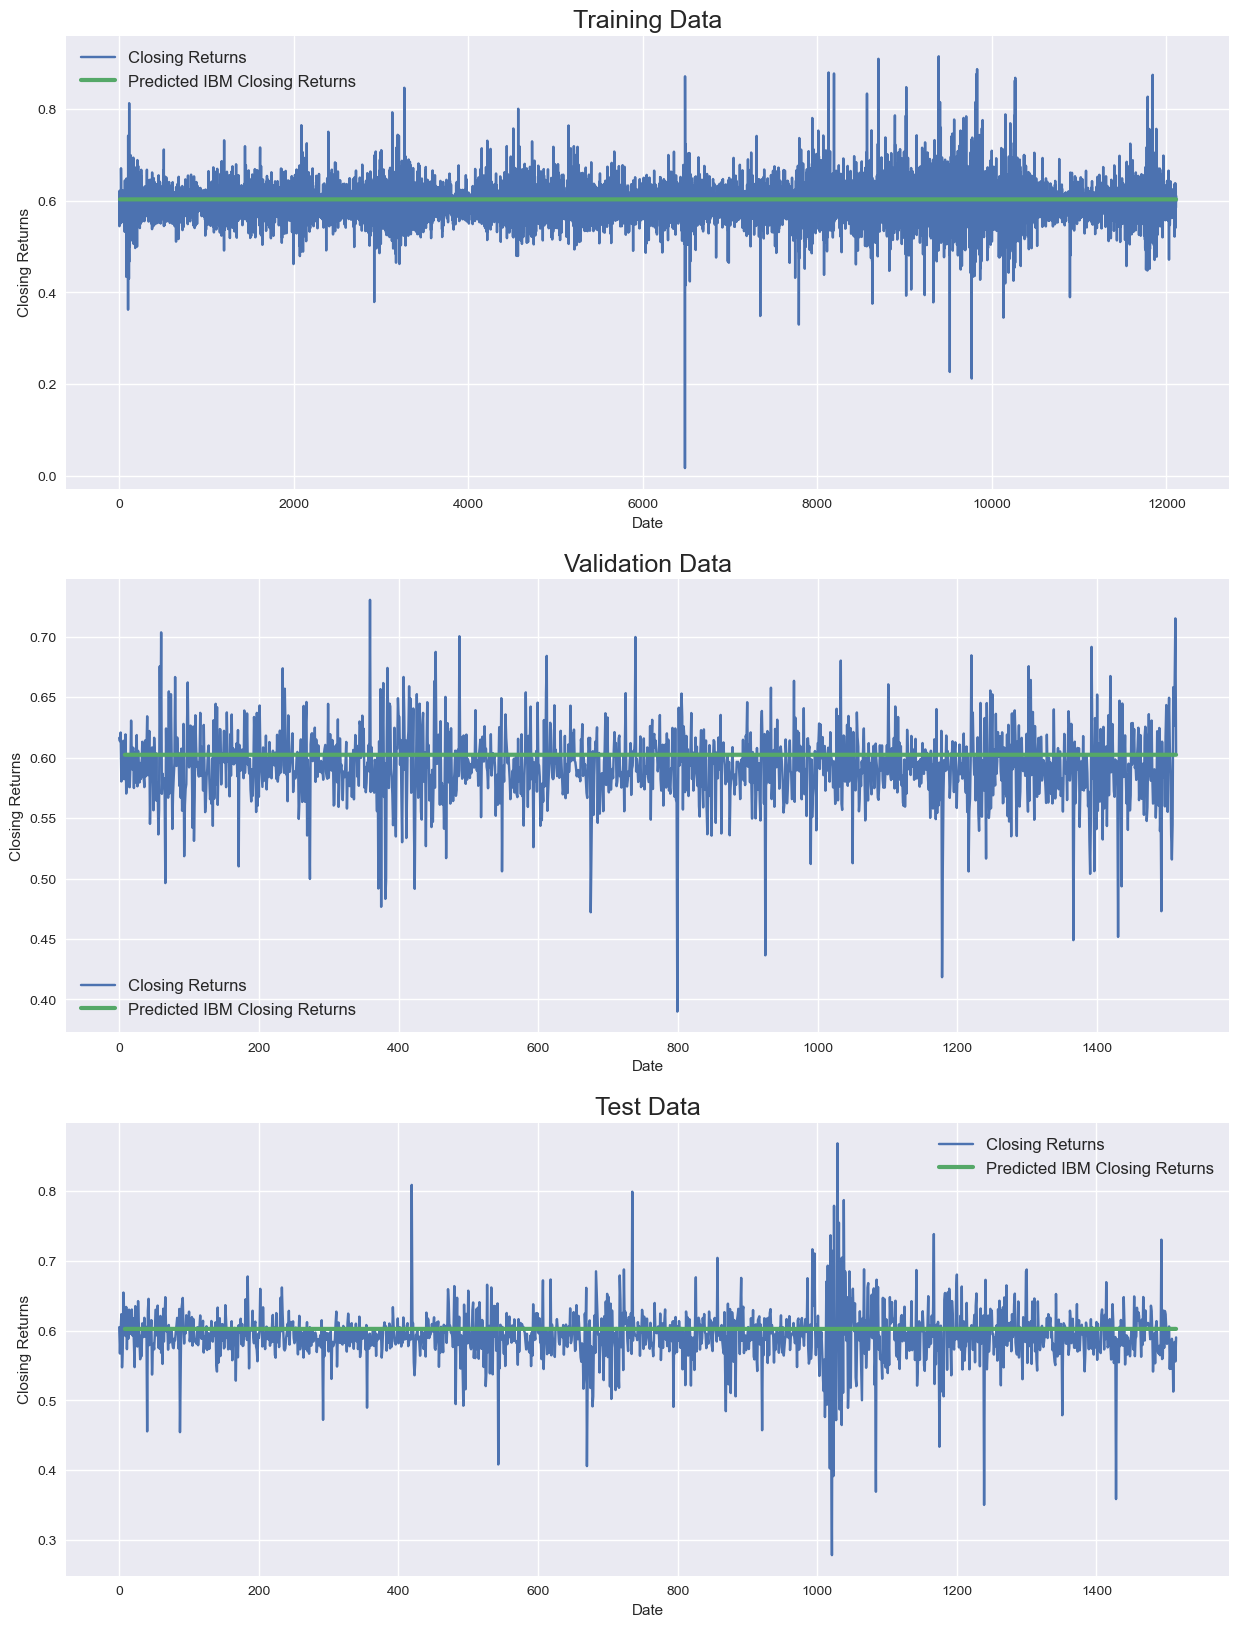

In [ ]:
pred_plot("", train_pred, val_pred, test_pred)

In [ ]:
modelEbm = create_model()
modelEbm.summary()

# callback = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

# checkpoint_callback = ModelCheckpoint(
#     filepath='model_checkpoint.h5',  # Filepath for saving the checkpoints
#     save_best_only=True,  # Save only the best model based on a monitored metric
#     monitor='val_loss',  # Metric to monitor for saving the best model
#     save_weights_only=False,  # Save the entire model (including architecture)
#     verbose=1  # Display progress messages
# )

callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding+TimeEmb.hdf5',
                                              monitor='val_loss',
                                              save_best_only=True, verbose=1)

modelEbm.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=4,
          callbacks=callback,
          validation_data=(X_val, y_val))

# model.evaluate(X_test, y_test, verbose=1)

modelEbm = tf.keras.models.load_model('/content/Transformer+TimeEmbedding+TimeEmb.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector,
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 5)]             0         []                            
                                                                                                  
 time2_vector (Time2Vector)  (None, 128, 2)               512       ['input_3[0][0]']             
                                                                                                  
 concatenate (Concatenate)   (None, 128, 7)               0         ['input_3[0][0]',             
                                                                     'time2_vector[0][0]']        
                                                                                                  
 transformer_encoder_9 (Tra  (None, 128, 7)               99114     ['concatenate[0][0]',   

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


375/375 [==============================] - 1041s 3s/step - loss: 0.0197 - mae: 0.0760 - mape: 13.1352 - val_loss: 9.0425e-04 - val_mae: 0.0214 - val_mape: 3.6990
Epoch 2/4
375/375 [==============================] - ETA: 0s - loss: 0.0030 - mae: 0.0422 - mape: 7.4609
Epoch 2: val_loss improved from 0.00090 to 0.00089, saving model to Transformer+TimeEmbedding+TimeEmb.hdf5
375/375 [==============================] - 982s 3s/step - loss: 0.0030 - mae: 0.0422 - mape: 7.4609 - val_loss: 8.8530e-04 - val_mae: 0.0211 - val_mape: 3.6185
Epoch 3/4
375/375 [==============================] - ETA: 0s - loss: 0.0029 - mae: 0.0415 - mape: 7.2796
Epoch 3: val_loss did not improve from 0.00089
375/375 [==============================] - 1013s 3s/step - loss: 0.0029 - mae: 0.0415 - mape: 7.2796 - val_loss: 0.0012 - val_mae: 0.0263 - val_mape: 4.5967
Epoch 4/4
375/375 [==============================] - ETA: 0s - loss: 0.0028 - mae: 0.0401 - mape: 7.0720
Epoch 4: val_loss did not improve from 0.00089
375/3

In [ ]:
#Calculate predication for training, validation and test data
train_predEmb = modelEbm.predict(X_train)
val_predEmb = modelEbm.predict(X_val)
test_predEmb = modelEbm.predict(X_test)

44/44 [==============================] - 38s 859ms/step


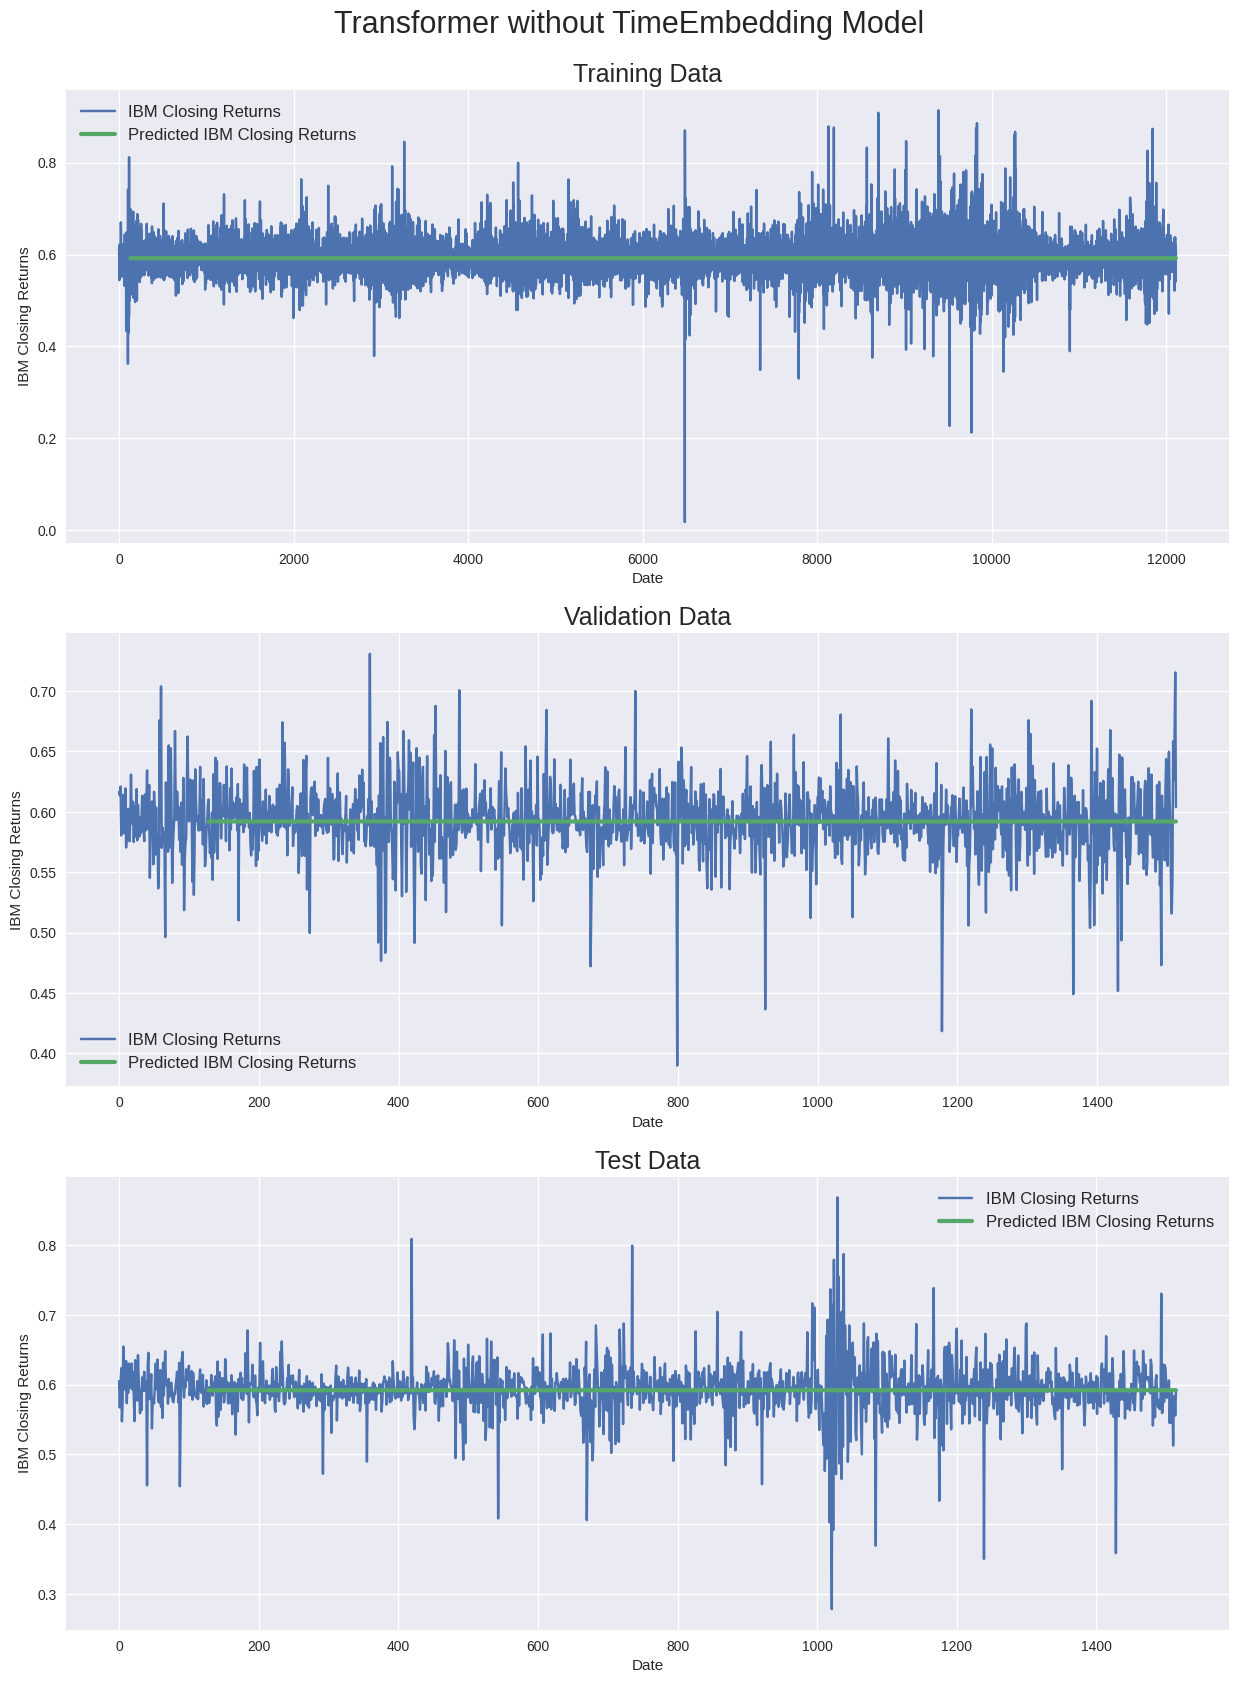

In [ ]:
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer without TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_arr[:, 3], label='IBM Closing Returns')
ax11.plot(np.arange(seq_len, train_predEmb.shape[0]+seq_len), train_predEmb, linewidth=3, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_arr[:, 3], label='IBM Closing Returns')
ax21.plot(np.arange(seq_len, val_predEmb.shape[0]+seq_len), val_predEmb, linewidth=3, label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('IBM Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_arr[:, 3], label='IBM Closing Returns')
ax31.plot(np.arange(seq_len, test_predEmb.shape[0]+seq_len), test_predEmb, linewidth=3, label='Predicted IBM Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('IBM Closing Returns')
ax31.legend(loc="best", fontsize=12)

# Data w/ Rolling Windows

In [ ]:
seq_len = 128
# batch_size = 32
# d_k = 256
# d_v = 256
# n_heads = 12
# ff_dim = 256

In [59]:
df_RW = stocks_data.copy()

# Moving average with a window of 10 days to all columns
df_RW[['Open', 'High', 'Low', 'Close', 'Volume']] = stocks_data[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(10).mean()

df_RW.dropna(how='any', axis=0, inplace=True)
df_RW.head(5)

DateTime      Open      High       Low     Close    Volume
9  1962-01-15 14:30:00  7.208413  7.245061  7.159337  1.550373  384405.0
10 1962-01-16 14:30:00  7.192479  7.229127  7.144678  1.547210  370284.0
11 1962-01-17 14:30:00  7.174633  7.204908  7.116635  1.540195  383620.5
12 1962-01-18 14:30:00  7.144041  7.181326  7.093690  1.535175  395388.0
13 1962-01-19 14:30:00  7.121734  7.160930  7.078394  1.533387  399310.5

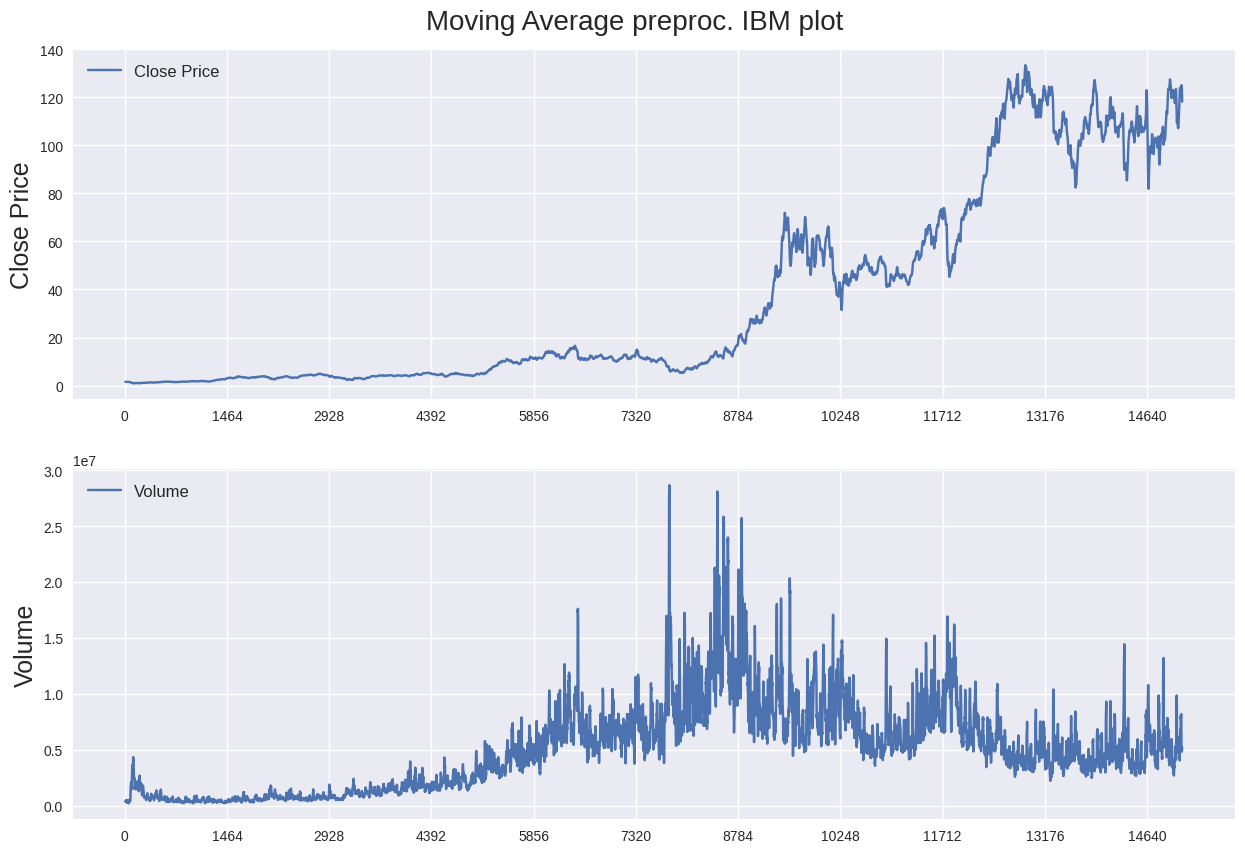

In [61]:
yahoo_data.stock_plot("Moving Average preproc. IBM plot", df_RW)

Train df shape: (12105, 5)
Val df shape: (1513, 5)
Test df shape: (1514, 5)


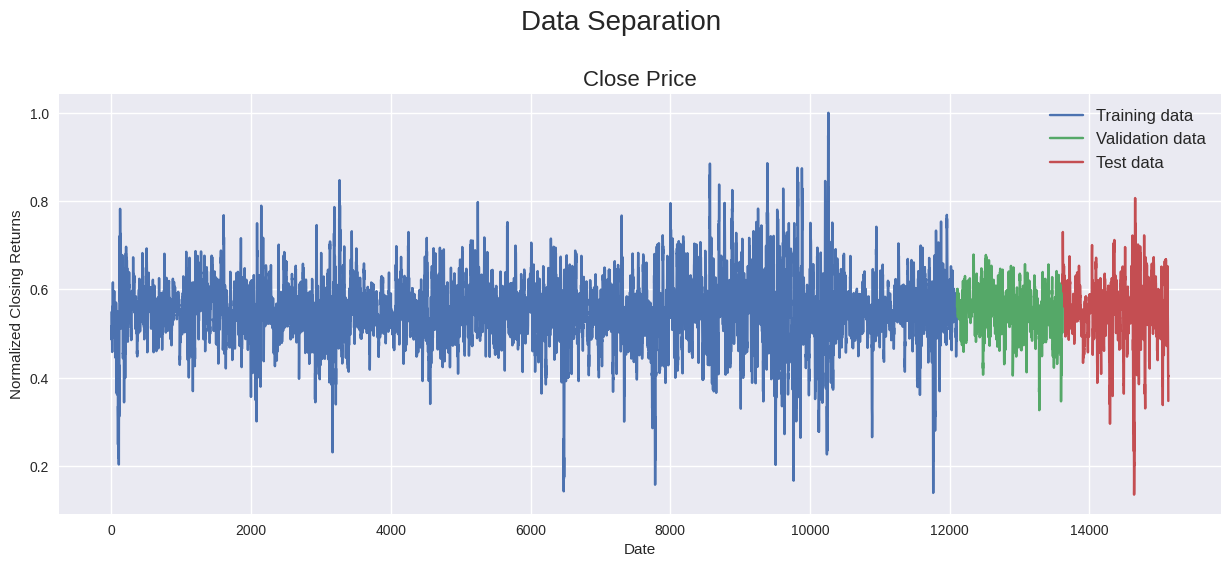

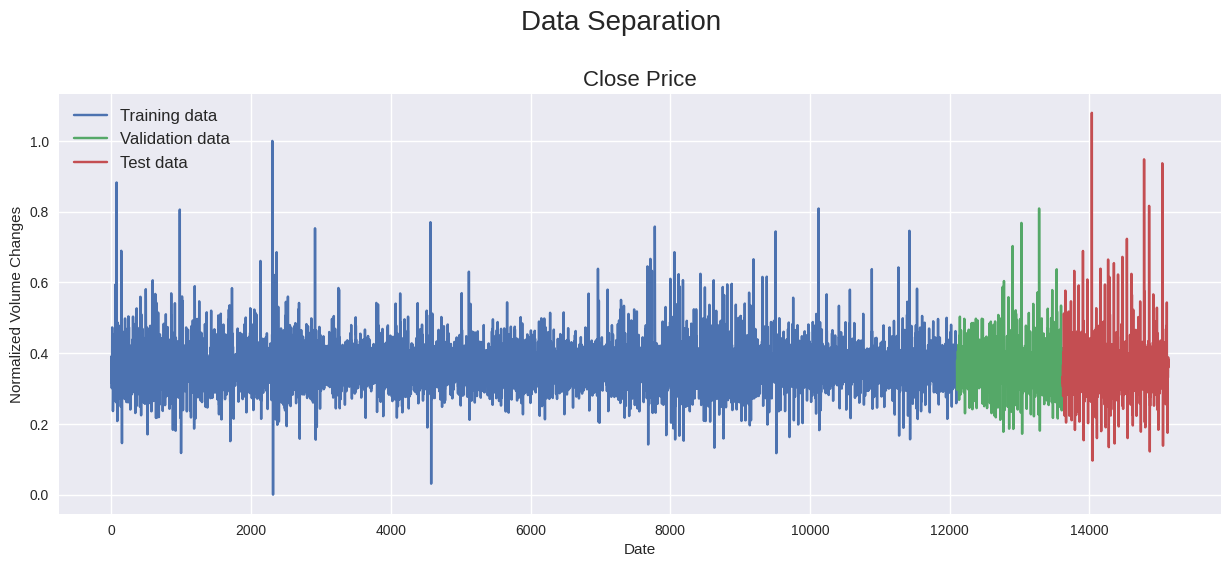

In [63]:
conv_df_RW = df_convert(df_RW)
preproc_df_RW = mm_norm(conv_df_RW)
# stock_plot("Moving Average preproc. IBM plot", preproc_df_RW)

dfRW_train, dfRW_val, dfRW_test = preprocessing.df_split(preproc_df_RW)
plot.split_plot(dfRW_train, dfRW_val, dfRW_test, param = 'Open', title =  "Close Price", y_lbl = 'Normalized Closing Returns')
plot.split_plot(dfRW_train, dfRW_val, dfRW_test, param = 'Volume', title =  "Close Price", y_lbl = 'Normalized Volume Changes')

In [64]:
RWX_train, RWy_train, RWX_val, RWy_val, RWX_test, RWy_test = preprocessing.chunks(seq_len, dfRW_train, dfRW_val, dfRW_test, target_col)

Train chunks set shape:  (12097, 8, 5) (12097,)
Val chunks set shape:  (1505, 8, 5) (1505,)
Test chunks set shape:  (1506, 8, 5) (1506,)


## No timeEmb

In [65]:
history = model.fit(
    RWX_train,
    RWy_train,
    # validation_split=0.2,
    epochs=2,
    batch_size=20,
    callbacks=callbacks,
    validation_data=(RWX_val, RWy_val))

Epoch 1/2
605/605 [==============================] - 119s 197ms/step - loss: 0.0268 - mean_squared_error: 0.0268 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - lr: 1.0000e-06
Epoch 2/2
605/605 [==============================] - 114s 188ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - val_loss: 0.0023 - val_mean_squared_error: 0.0023 - lr: 3.4300e-05


379/379 [==============================] - 32s 85ms/step


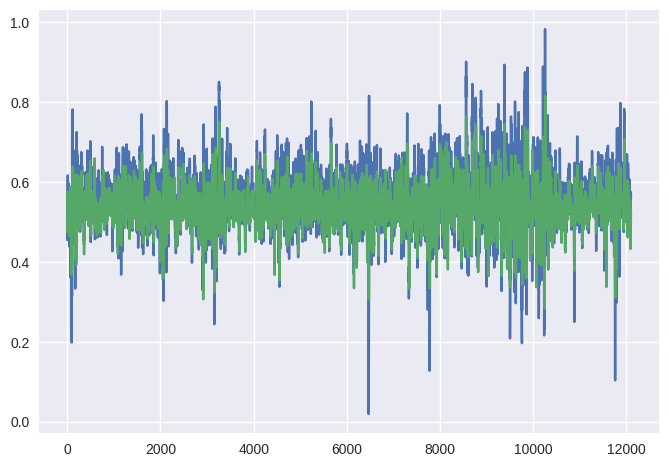

In [66]:
a = model.predict(RWX_train)

# 2 epo w 60 num_heads
plt.plot(RWy_train, label='original data')
plt.plot(a, label='predicted data')

48/48 [==============================] - 5s 100ms/step


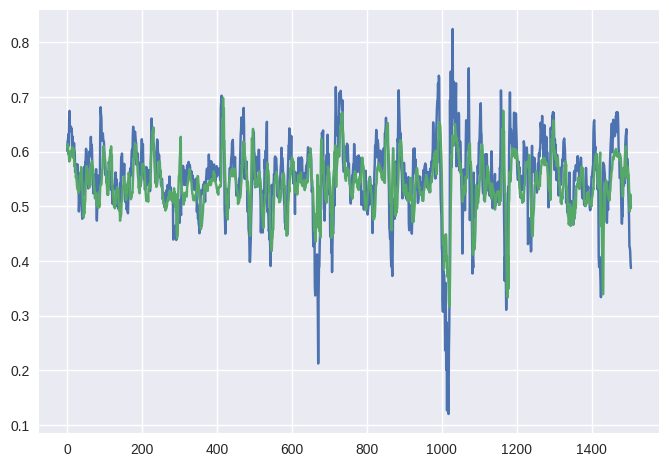

In [67]:
a = model.predict(RWX_test)

# 2 epo w 60 num_heads
plt.plot(RWy_test, label='original data')
plt.plot(a, label='predicted data')

In [68]:
history = model.fit(
    RWX_train,
    RWy_train,
    # validation_split=0.2,
    epochs=10,
    batch_size=20,
    callbacks=callbacks,
    validation_data=(RWX_val, RWy_val))

Epoch 1/10
605/605 [==============================] - 122s 201ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - val_loss: 0.0021 - val_mean_squared_error: 0.0021 - lr: 1.0000e-06
Epoch 2/10
605/605 [==============================] - 113s 187ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - val_loss: 0.0020 - val_mean_squared_error: 0.0020 - lr: 3.4300e-05
Epoch 3/10
605/605 [==============================] - 125s 206ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - lr: 6.7600e-05
Epoch 4/10
605/605 [==============================] - 121s 200ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0023 - val_mean_squared_error: 0.0023 - lr: 1.0090e-04
Epoch 5/10
605/605 [==============================] - 114s 188ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0015 - val_mean_squared_error: 0.0015 - lr: 1.3420e-04
Epoch 6/10
605/605 [==============================] - 116s 192ms/step - loss: 0.0054 

379/379 [==============================] - 32s 85ms/step


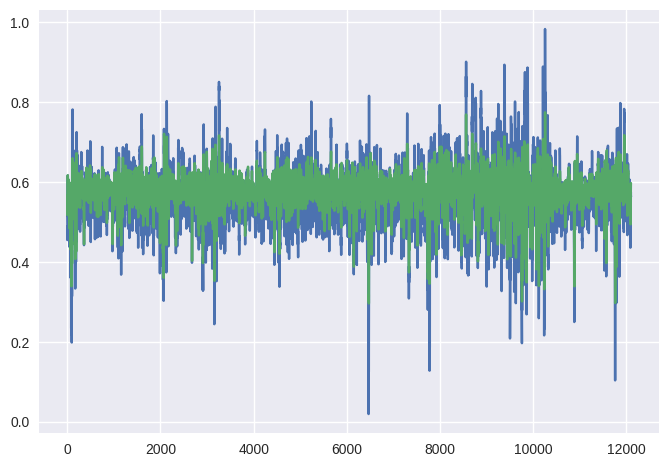

In [69]:
b = model.predict(RWX_train)

# 10 epo w 60 num_heads
plt.plot(RWy_train, label='original data')
plt.plot(b, label='predicted data')

48/48 [==============================] - 4s 75ms/step


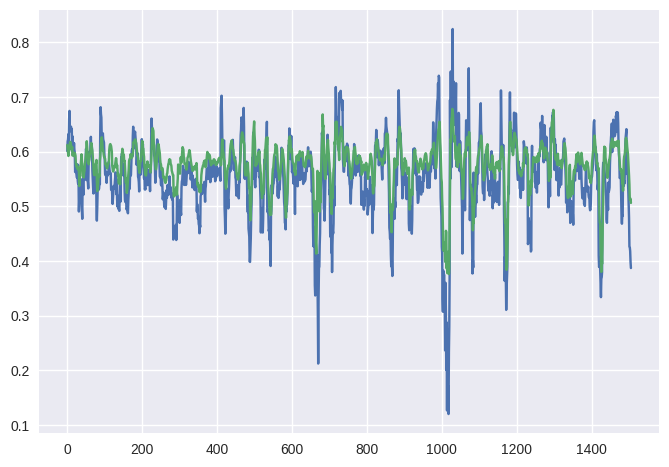

In [71]:
b = model.predict(RWX_test)

# 10 epo w 60 num_heads
plt.plot(RWy_test, label='original data')
plt.plot(b, label='predicted data')

In [ ]:
RW_path = '/content/drive/My Drive/Colab Notebooks/MultiTimeSeries/TransformerRW.hdf5'

RWcallback = tf.keras.callbacks.ModelCheckpoint(RW_path,
                                              monitor='val_loss',
                                              save_best_only=True,
                                              save_weights_only=False,  # Save the entire model (including architecture)
                                              verbose=1)

time_callback = TimeCallback()

In [ ]:
# model_RW = create_model_TimeEmb()
model_RW = create_model_noTimEmb()

model_RW.fit(RWX_train, RWy_train,
          batch_size=batch_size,
          epochs = 6,
          callbacks=[RWcallback, time_callback],
          validation_data=(RWX_val, RWy_val))

Epoch 1/6
379/379 [==============================] - ETA: 0s - loss: 0.0220 - mae: 0.0912 - mape: 16.9539
Epoch 1: val_loss improved from inf to 0.00220, saving model to /content/drive/My Drive/Colab Notebooks/MultiTimeSeries/TransformerRW.hdf5
Epoch 1 took 128.95 seconds
379/379 [==============================] - 129s 205ms/step - loss: 0.0220 - mae: 0.0912 - mape: 16.9539 - val_loss: 0.0022 - val_mae: 0.0378 - val_mape: 7.2299
Epoch 2/6
379/379 [==============================] - ETA: 0s - loss: 0.0045 - mae: 0.0510 - mape: 9.8180
Epoch 2: val_loss did not improve from 0.00220
Epoch 2 took 68.92 seconds
379/379 [==============================] - 69s 182ms/step - loss: 0.0045 - mae: 0.0510 - mape: 9.8180 - val_loss: 0.0053 - val_mae: 0.0633 - val_mape: 11.1220
Epoch 3/6
378/379 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0492 - mape: 9.5207
Epoch 3: val_loss did not improve from 0.00220
Epoch 3 took 68.57 seconds
379/379 [==============================] - 69s 181

48/48 [==============================] - 4s 82ms/step


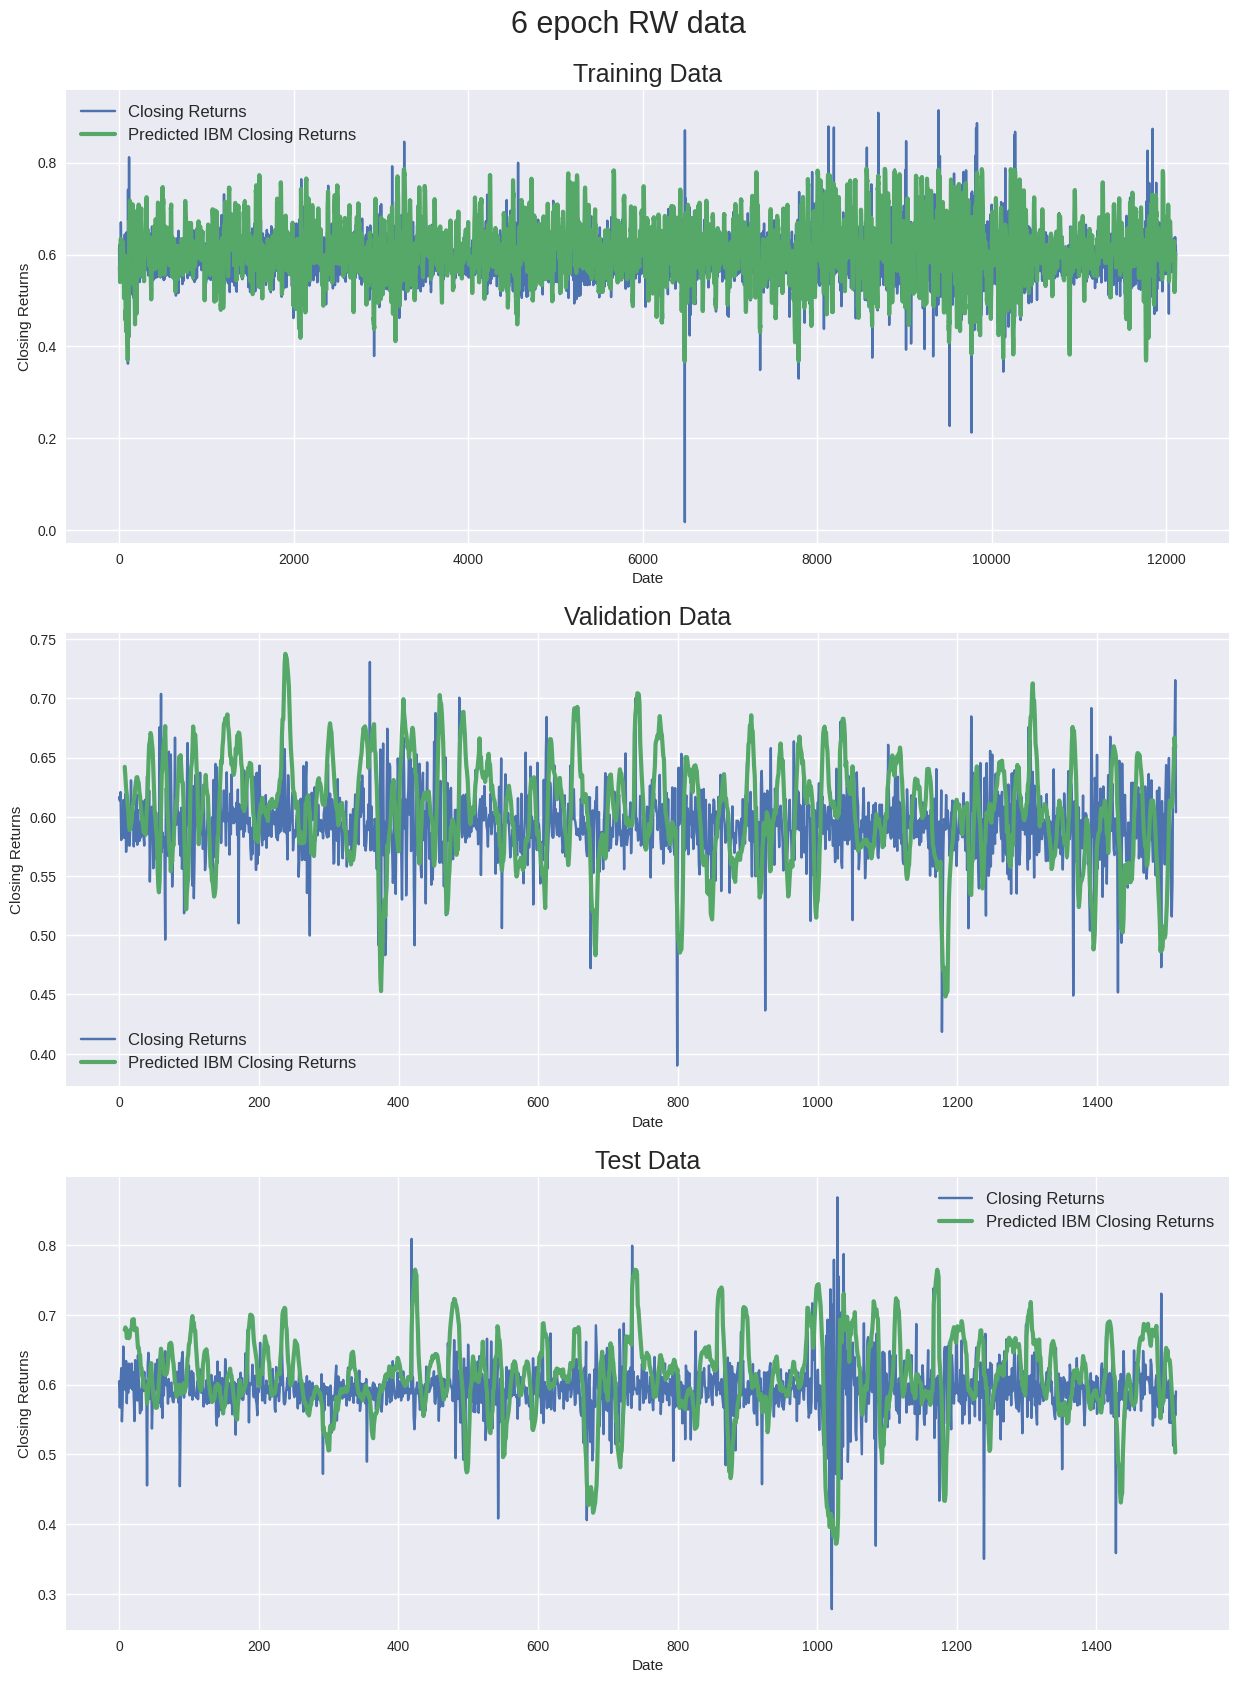

In [ ]:
# every time it gives different results
train_predRW = model_RW.predict(RWX_train)
val_predRW = model_RW.predict(RWX_val)
test_predRW = model_RW.predict(RWX_test)

pred_plot("6 epoch RW data", train_predRW, val_predRW, test_predRW)

48/48 [==============================] - 2s 46ms/step


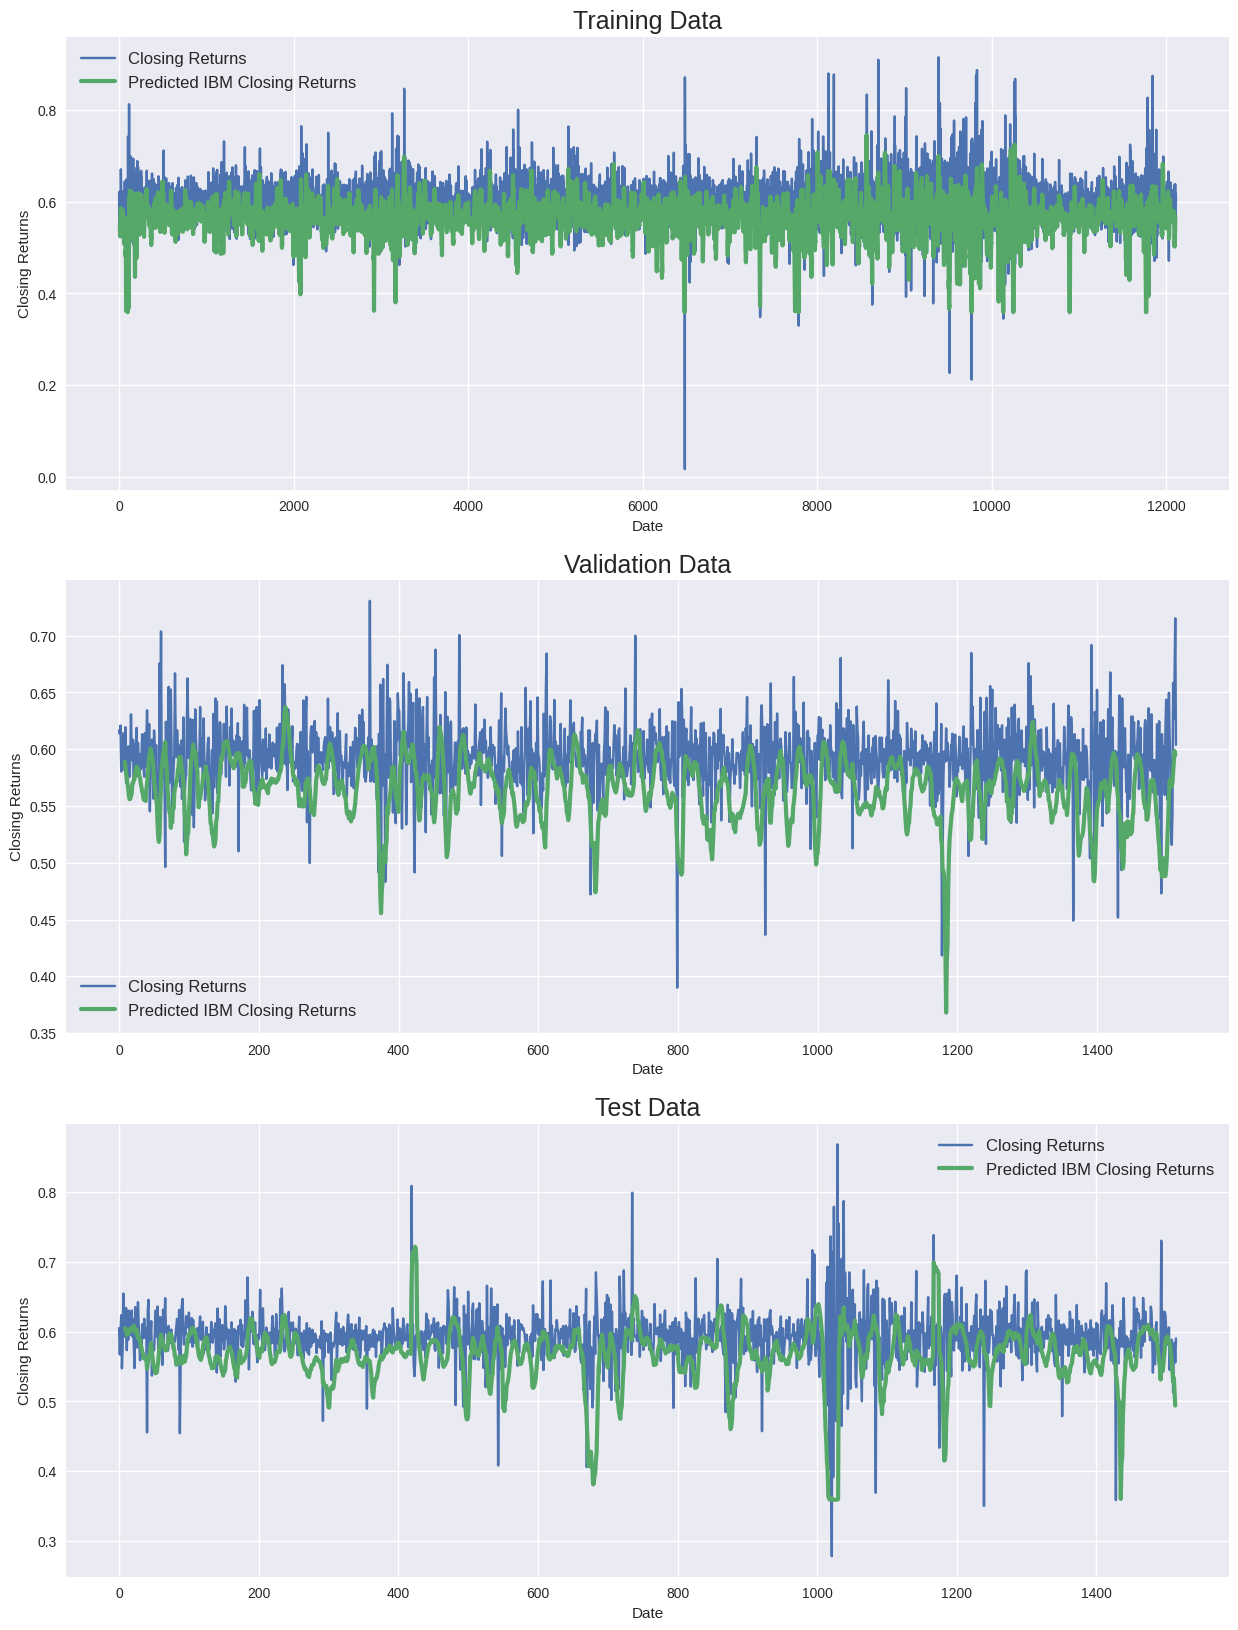

In [ ]:
# don't understant why are predictions of an initial model and by the same loaded model different?
loaded_modelRW = tf.keras.models.load_model(RW_path,
                                   custom_objects={'Time2Vector': Time2Vector,
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


a = loaded_modelRW.predict(RWX_train)
b = loaded_modelRW.predict(RWX_val)
c = loaded_modelRW.predict(RWX_test)

pred_plot("", a, b, c)

In [ ]:
# Encoders are different. Is it ok??
# Compare the architectures
model_RW.summary()
loaded_modelRW.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 8, 5)]               0         []                            
                                                                                                  
 transformer_encoder_6 (Tra  (None, 8, 5)                 73502     ['input_2[0][0]',             
 nsformerEncoder)                                                    'input_2[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 transformer_encoder_7 (Tra  (None, 8, 5)                 73502     ['transformer_encoder_6[0][0]'
 nsformerEncoder)                                                   , 'transformer_encoder_6

### pretrained (on RW data) model dealing with raw data

48/48 [==============================] - 4s 78ms/step


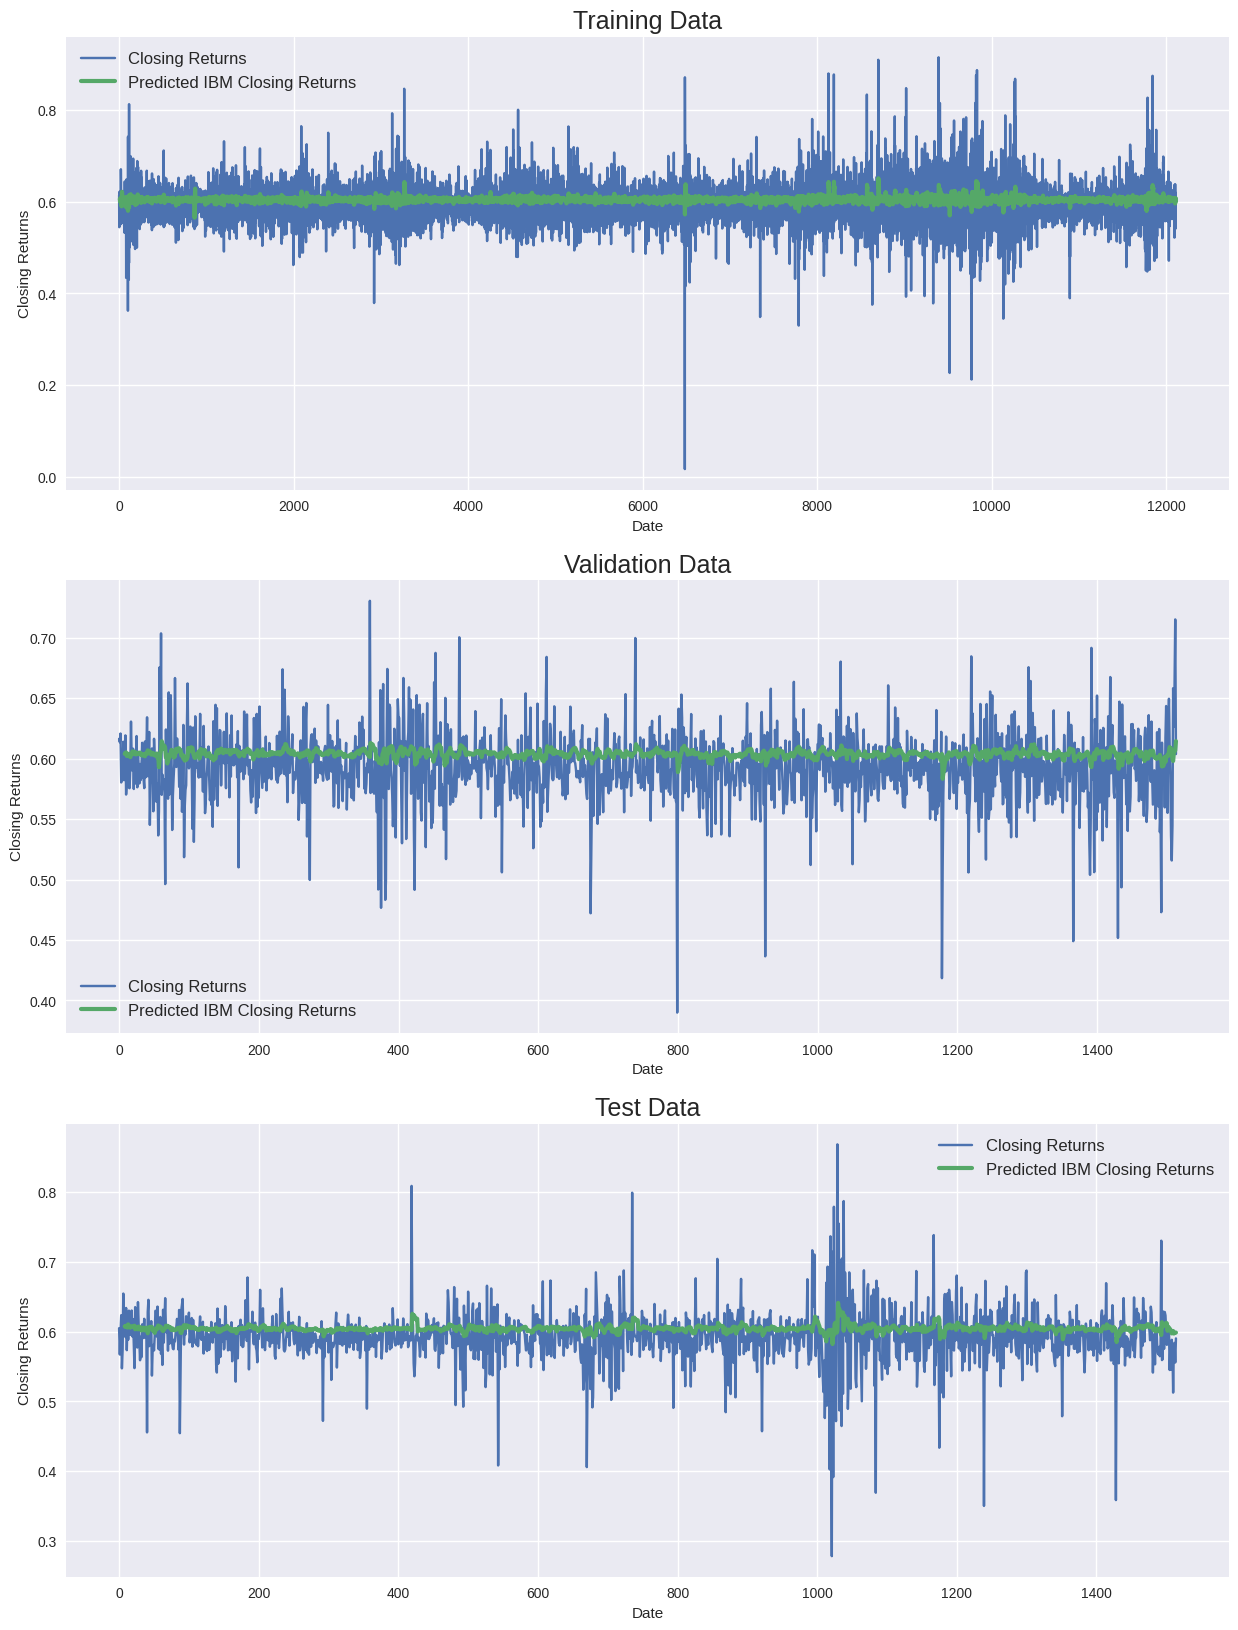

In [ ]:
train_predRW2 = model_RW.predict(X_train)
val_predRW2 = model_RW.predict(X_val)
test_predRW2 = model_RW.predict(X_test)

pred_plot("", train_predRW2, val_predRW2, test_predRW2)

48/48 [==============================] - 2s 47ms/step


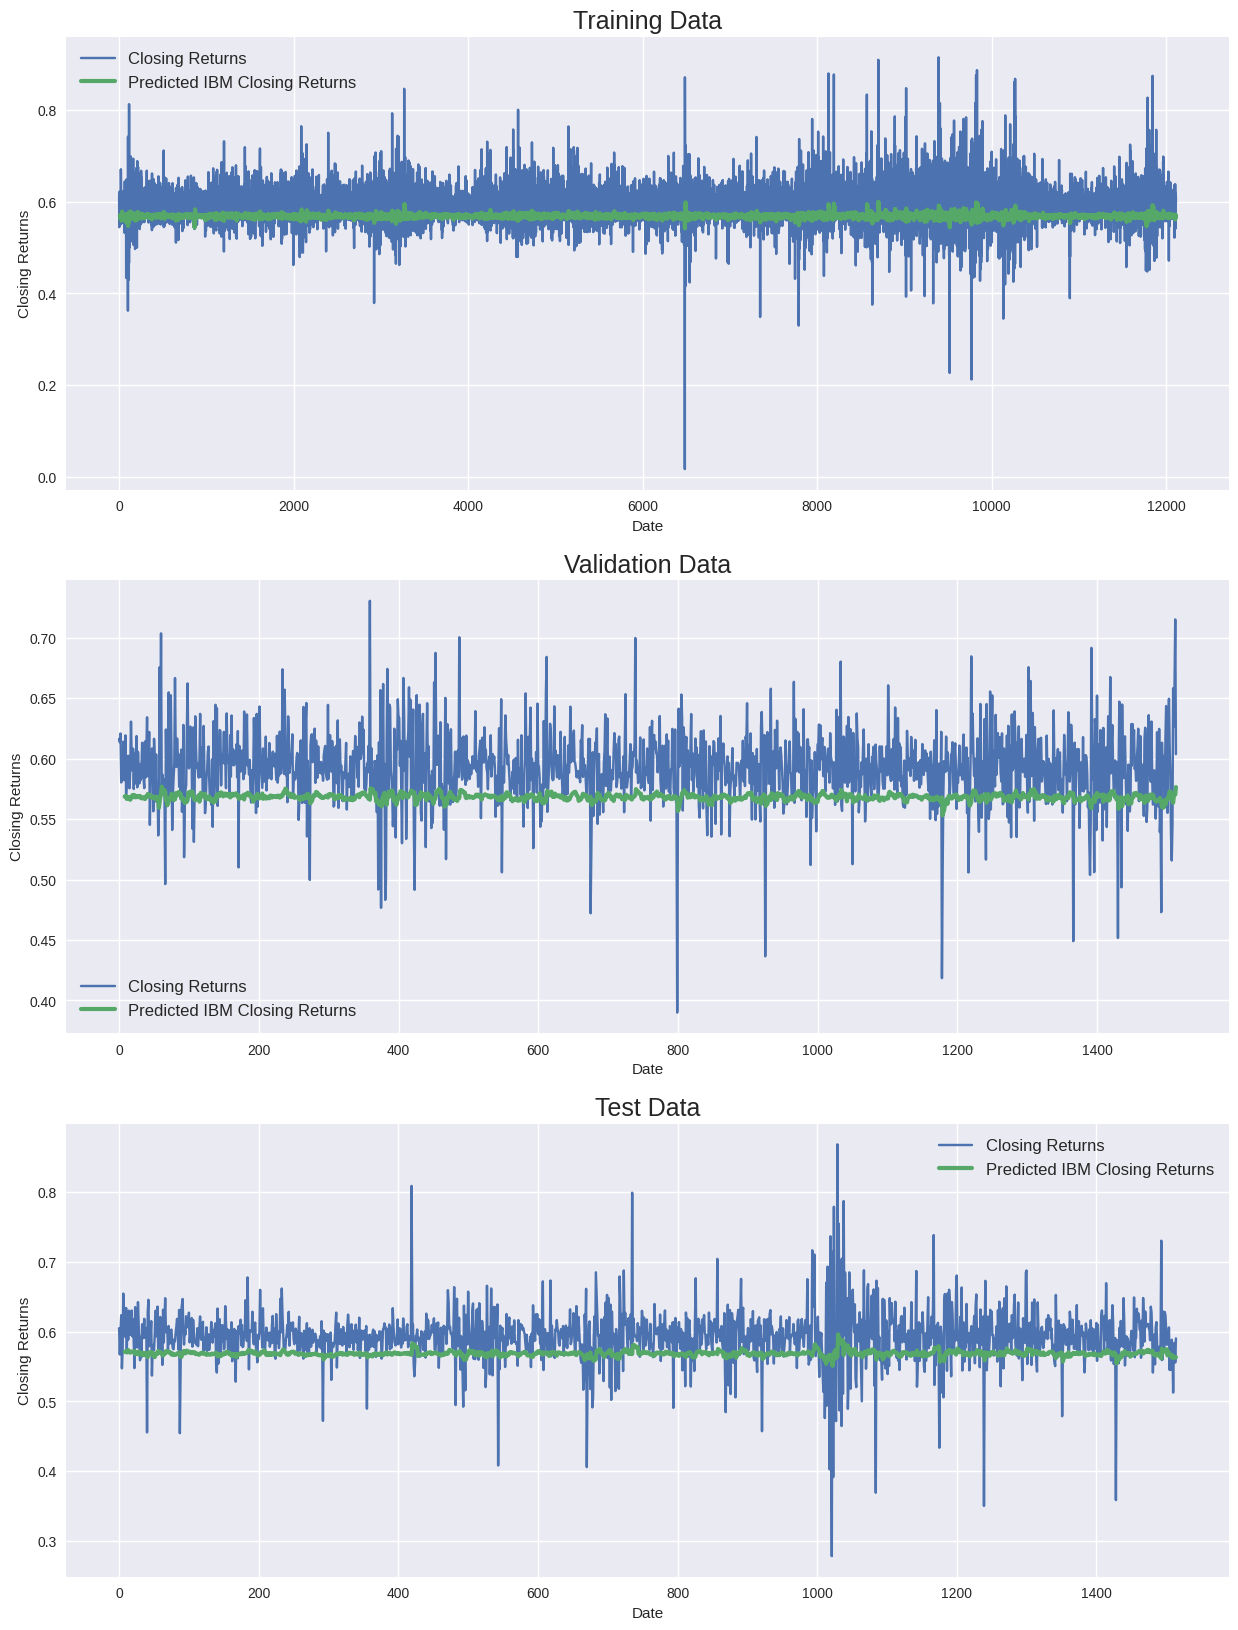

In [ ]:
train_predRW22 = loaded_modelRW.predict(X_train)
val_predRW22 = loaded_modelRW.predict(X_val)
test_predRW22 = loaded_modelRW.predict(X_test)

pred_plot("", train_predRW22, val_predRW22, test_predRW22)

In [ ]:
# print("Original RW test data: ", dfRW_test.values[:, 3])
# print("Original RW test pred data: ", test_predRW)

In [ ]:
# print("Original test data: ", df_test.values[:, 3])
# print("Original test pred data: ", test_predRW2)

Further training on original data

Epoch 1/6
379/379 [==============================] - ETA: 0s - loss: 0.0024 - mae: 0.0368 - mape: 6.5171
Epoch 1: val_loss improved from 0.00165 to 0.00089, saving model to /content/drive/My Drive/Colab Notebooks/MultiTimeSeries/TransformerRW.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1 took 108.57 seconds
379/379 [==============================] - 109s 204ms/step - loss: 0.0024 - mae: 0.0368 - mape: 6.5171 - val_loss: 8.8580e-04 - val_mae: 0.0212 - val_mape: 3.6238
Epoch 2/6
379/379 [==============================] - ETA: 0s - loss: 0.0023 - mae: 0.0358 - mape: 6.3399
Epoch 2: val_loss did not improve from 0.00089
Epoch 2 took 69.61 seconds
379/379 [==============================] - 70s 184ms/step - loss: 0.0023 - mae: 0.0358 - mape: 6.3399 - val_loss: 8.9136e-04 - val_mae: 0.0213 - val_mape: 3.6570
Epoch 3/6
379/379 [==============================] - ETA: 0s - loss: 0.0022 - mae: 0.0354 - mape: 6.2755
Epoch 3: val_loss did not improve from 0.00089
Epoch 3 took 72.79 seconds
379/379 [==============================] - 73s 192ms/step - loss: 0.0022 - mae: 0.0354 - mape: 6.2755 - val_loss: 8.8967e-04 - val_mae: 0.0213 - val_mape: 3.6230
Epoch 4/6
379/379 [==============================] - ETA: 0s - loss: 0.0022 - mae: 0.0347 - mape: 6.1670
Epoch 4: val_loss did 

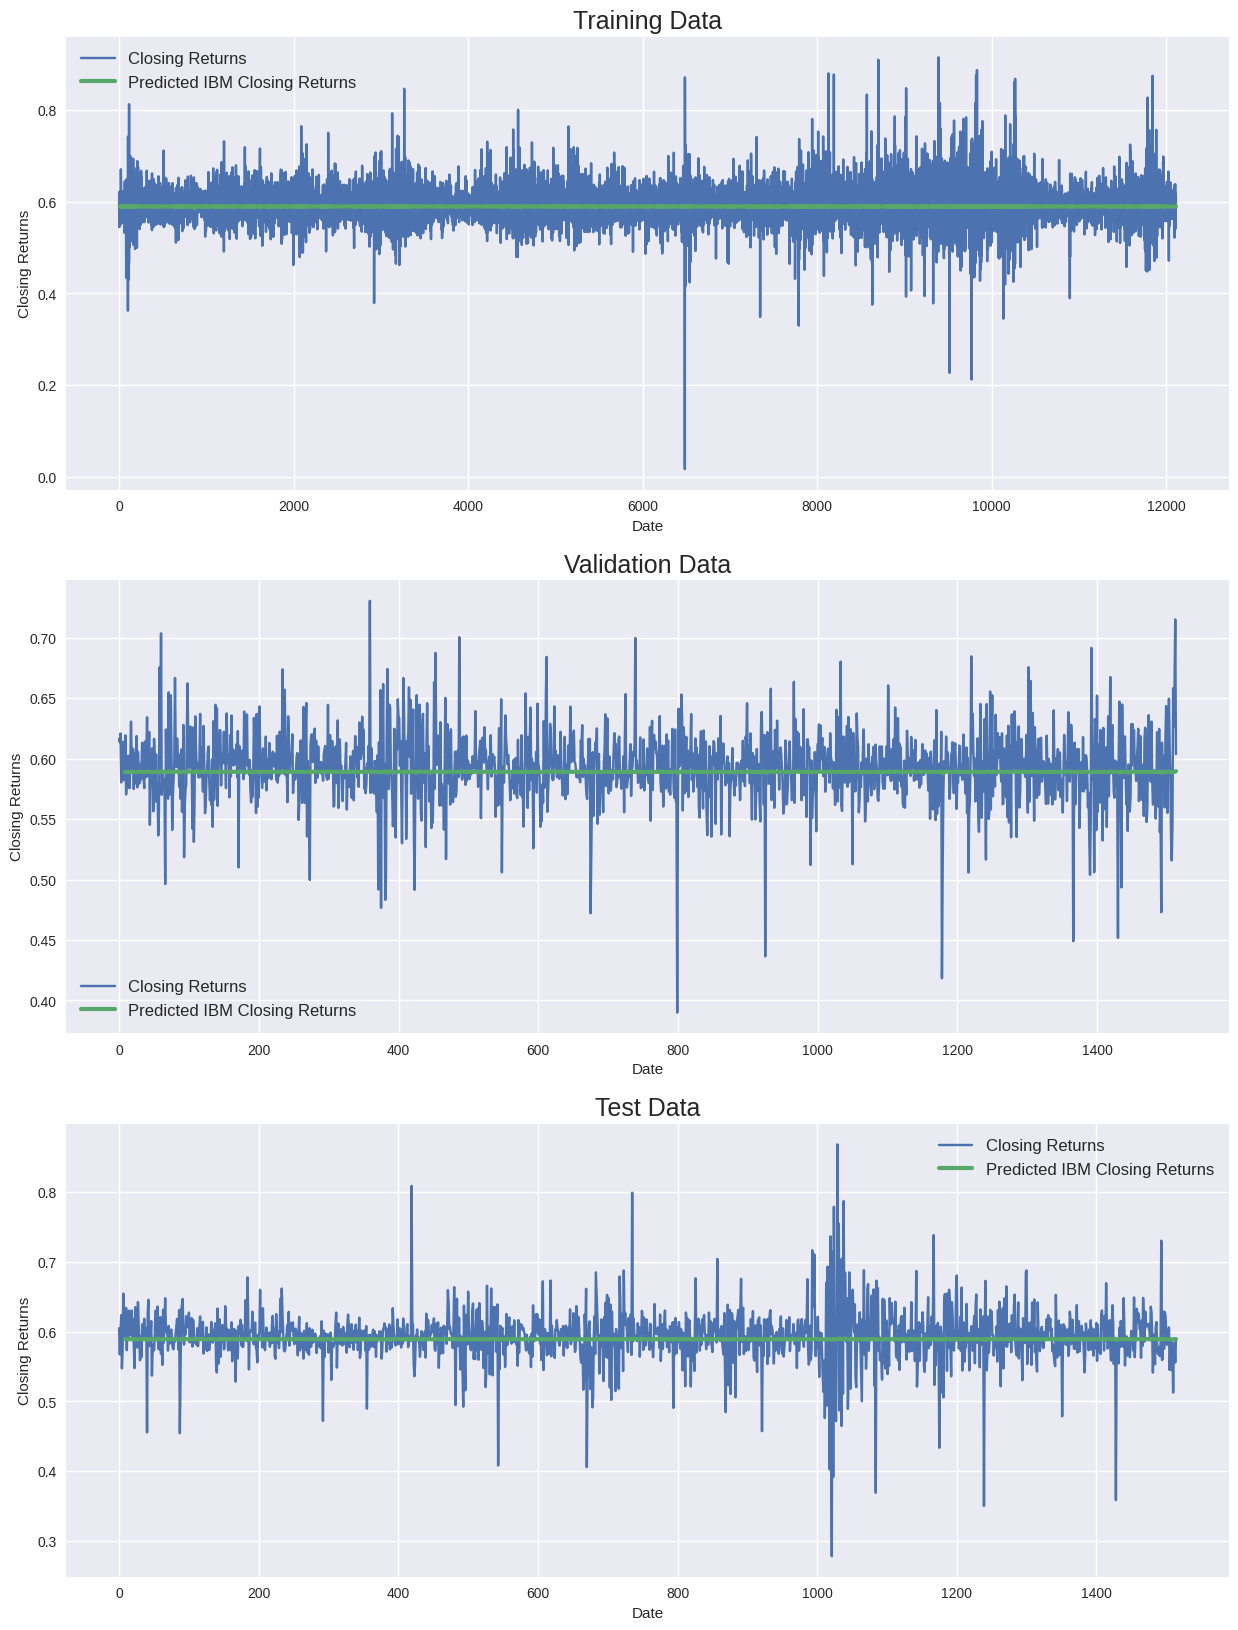

In [ ]:
# to continue training
loaded_modelRW = tf.keras.models.load_model(RW_path,
                                   custom_objects={'Time2Vector': Time2Vector,
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})

loaded_modelRW.fit(X_train, y_train,
                 batch_size=batch_size,
                 epochs = 6,
                 callbacks=[RWcallback, time_callback],
                 validation_data=(X_val, y_val))

train_RW_orig = loaded_modelRW.predict(X_train)
val_RW_orig = loaded_modelRW.predict(X_val)
test_RW_orig = loaded_modelRW.predict(X_test)

pred_plot("", train_RW_orig, val_RW_orig, test_RW_orig)